# Exploratory Data Analysis (EDA)
## Joint Aspect Extraction & Sentiment Classification
### SemEval Restaurant Reviews Dataset (2014, 2015, 2016)
#
---
#
## 📊 Project Overview
#
This notebook performs comprehensive Exploratory Data Analysis on three SemEval restaurant review datasets for the task of:
- **Aspect Term Extraction**: Identifying specific aspects mentioned in reviews (e.g., "food", "service", "ambiance")
- **Aspect Sentiment Classification**: Determining the sentiment polarity towards each aspect (positive, negative, neutral, conflict)
#
### 🎯 Objectives
1. Understand the structure and characteristics of each dataset independently
2. Analyze sentiment distribution and class imbalance
3. Identify data quality issues and preprocessing needs
4. Enable comparison with SOTA (State-of-the-Art) models on individual datasets
5. Extract actionable insights for model development
#
### 📚 Datasets
- **SemEval-2014 Task 4**: Restaurant reviews with aspect-level annotations
- **SemEval-2015 Task 12**: Restaurant reviews with aspect-level annotations  
- **SemEval-2016 Task 5**: Restaurant reviews with aspect-level annotations
#
Each dataset will be analyzed **separately** to maintain dataset integrity for independent model training and evaluation.



---
#
## 1️⃣ Environment Setup
#
Setting up libraries, configurations, and helper functions.



In [22]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("⚠️ WordCloud not available. Install with: pip install wordcloud")

# NLP
import re
from collections import Counter
try:
    import nltk
    from nltk.util import ngrams
    NLTK_AVAILABLE = True
except ImportError:
    NLTK_AVAILABLE = False
    print("⚠️ NLTK not available. Install with: pip install nltk")

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Plotting Style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



✅ Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.6


In [23]:
# Helper Functions for Reusability

def print_section_header(title):
    """Print formatted section header"""
    print("\\n" + "="*80)
    print(f"  {title}")
    print("="*80 + "\\n")

def calculate_class_weights(df, column='polarity'):
    """Calculate class distribution and imbalance metrics"""
    dist = df[column].value_counts()
    percentages = (dist / len(df) * 100).round(2)
    
    result_df = pd.DataFrame({
        'Count': dist,
        'Percentage': percentages
    })
    
    # Calculate imbalance ratio
    max_count = dist.max()
    min_count = dist.min()
    imbalance_ratio =max_count / min_count if min_count > 0 else np.inf
    
    return result_df, imbalance_ratio

def plot_sentiment_distribution(df, dataset_name, ax=None):
    """Plot sentiment distribution with percentages"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    sentiment_counts = df['polarity'].value_counts()
    colors_map = {
        'positive': '#2ecc71',
        'negative': '#e74c3c',
        'neutral': '#95a5a6',
        'conflict': '#f39c12'
    }
    colors = [colors_map.get(sent, '#3498db') for sent in sentiment_counts.index]
    
    bars = ax.bar(sentiment_counts.index, sentiment_counts.values, color=colors, edgecolor='black', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\\n({height/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(f'Sentiment Distribution - {dataset_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Sentiment Polarity', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_ylim(0, sentiment_counts.max() * 1.15)
    
    return ax

print("✅ Helper functions defined successfully!")



✅ Helper functions defined successfully!


---
#
## 2️⃣ Data Loading
#
Loading the three processed datasets from CSV files.



In [24]:
# Define data paths
DATA_DIR = Path("../Data/Processed_Data")

# File paths
file_2014 = DATA_DIR / "2014_rest_reviews.csv"
file_2015 = DATA_DIR / "2015_rest_reviews.csv"
file_2016 = DATA_DIR / "2016_rest_reviews.csv"

# Verify files exist
for file_path in [file_2014, file_2015, file_2016]:
    if not file_path.exists():
        print(f"❌ File not found: {file_path}")
    else:
        print(f"✅ Found: {file_path}")



✅ Found: ../Data/Processed_Data/2014_rest_reviews.csv
✅ Found: ../Data/Processed_Data/2015_rest_reviews.csv
✅ Found: ../Data/Processed_Data/2016_rest_reviews.csv


In [25]:
# Load datasets
df_2014 = pd.read_csv(file_2014)
df_2015 = pd.read_csv(file_2015)
df_2016 = pd.read_csv(file_2016)

print_section_header("DATA LOADED SUCCESSFULLY")
print(f"📄 Dataset 2014: {df_2014.shape[0]:,} rows × {df_2014.shape[1]} columns")
print(f"📄 Dataset 2015: {df_2015.shape[0]:,} rows × {df_2015.shape[1]} columns")
print(f"📄 Dataset 2016: {df_2016.shape[0]:,} rows × {df_2016.shape[1]} columns")
print(f"\\n📊 Total Records: {df_2014.shape[0] + df_2015.shape[0] + df_2016.shape[0]:,}")



\n================================================================================
  DATA LOADED SUCCESSFULLY
================================================================================\n
📄 Dataset 2014: 4,923 rows × 6 columns
📄 Dataset 2015: 2,838 rows × 6 columns
📄 Dataset 2016: 3,366 rows × 6 columns
\n📊 Total Records: 11,127


In [26]:
# Quick preview of each dataset
print_section_header("DATASET PREVIEWS")

print("\\n🔹 2014 Dataset Sample:")
display(df_2014.head(3))

print("\\n🔹 2015 Dataset Sample:")
display(df_2015.head(3))

print("\\n🔹 2016 Dataset Sample:")
display(df_2016.head(3))



\n================================================================================
  DATASET PREVIEWS
================================================================================\n
\n🔹 2014 Dataset Sample:


sentence_id  \
0   2014_0001   
1   2014_0002   
2   2014_0003   

                                                                 sentence  \
0                                         The bread is top notch as well.   
1  I have to say they have one of the fastest delivery times in the city.   
2                             Food is always fresh and hot- ready to eat!   

           aspect  polarity  from  to  
0           bread  positive     4   9  
1  delivery times  positive    43  57  
2            Food  positive     0   4

\n🔹 2015 Dataset Sample:


sentence_id                             sentence    aspect  from  to  \
0   2015_0001                        Love Al Di La  Al Di La     5  13   
1   2015_0002  I recommend this place to everyone.     place    17  22   
2   2015_0003                          Great food.      food     6  10   

   polarity  
0  positive  
1  positive  
2  positive

\n🔹 2016 Dataset Sample:


sentence_id  \
0   2016_0001   
1   2016_0002   
2   2016_0003   

                                                                                              sentence  \
0                        Judging from previous posts this used to be a good place, but not any longer.   
1  We, there were four of us, arrived at noon - the place was empty - and the staff acted like we w...   
2  They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our ...   

     aspect  from  to  polarity  
0     place    51  56  negative  
1     staff    75  80  negative  
2  [ASPECT]     0   0  negative

---
#
## 3️⃣ Dataset Profiling
#
Comprehensive profiling of each dataset including dimensions, data types, missing values, and duplicates.



In [27]:
def profile_dataset(df, dataset_name):
    """Generate comprehensive dataset profile"""
    print_section_header(f"PROFILING: {dataset_name}")
    
    print(f"📏 Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\\n📋 Column Names: {list(df.columns)}")
    
    print("\\n🔤 Data Types:")
    print(df.dtypes)
    
    print("\\n❓ Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("  ✅ No missing values detected!")
    else:
        missing_df = pd.DataFrame({
            'Count': missing[missing > 0],
            'Percentage': (missing[missing > 0] / len(df) * 100).round(2)
        })
        print(missing_df)
    
    print("\\n🔁 Duplicate Rows:")
    duplicates = df.duplicated().sum()
    print(f"  Total: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    print("\\n📊 Summary Statistics:")
    display(df.describe(include='all').T)
    
    print("\\n" + "-"*80)

# Profile each dataset
profile_dataset(df_2014, "SemEval 2014")
profile_dataset(df_2015, "SemEval 2015")
profile_dataset(df_2016, "SemEval 2016")



\n================================================================================
  PROFILING: SemEval 2014
================================================================================\n
📏 Dimensions: 4,923 rows × 6 columns
💾 Memory Usage: 1.71 MB
\n📋 Column Names: ['sentence_id', 'sentence', 'aspect', 'polarity', 'from', 'to']
\n🔤 Data Types:
sentence_id    object
sentence       object
aspect         object
polarity       object
from            int64
to              int64
dtype: object
\n❓ Missing Values:
  ✅ No missing values detected!
\n🔁 Duplicate Rows:
  Total: 0 (0.00%)
\n📊 Summary Statistics:


count unique  \
sentence_id    4923   2681   
sentence       4923   2627   
aspect         4923   1651   
polarity       4923      4   
from         4923.0    NaN   
to           4923.0    NaN   

                                                                                                             top  \
sentence_id                                                                                            2014_0544   
sentence     Fresh veggies, all sorts of middle eastern spreads, cheese and falafel, soup, fish, rice, root v...   
aspect                                                                                                      food   
polarity                                                                                                positive   
from                                                                                                         NaN   
to                                                                                                           NaN   

             freq       mean        std  min   25%   50%   75%    max  
sentence_id    13        NaN        NaN  NaN   NaN   NaN   NaN    NaN  
sentence       13        NaN        NaN  NaN   NaN   NaN   NaN    NaN  
aspect        493        NaN        NaN  NaN   NaN   NaN   NaN    NaN  
polarity     2960        NaN        NaN  NaN   NaN   NaN   NaN    NaN  
from          NaN  43.667479  40.276691  0.0  12.0  34.0  64.0  340.0  
to            NaN  52.047735  40.975299  4.0  21.0  42.0  72.0  344.0

\n--------------------------------------------------------------------------------
\n================================================================================
  PROFILING: SemEval 2015
================================================================================\n
📏 Dimensions: 2,838 rows × 6 columns
💾 Memory Usage: 0.94 MB
\n📋 Column Names: ['sentence_id', 'sentence', 'aspect', 'from', 'to', 'polarity']
\n🔤 Data Types:
sentence_id    object
sentence       object
aspect         object
from            int64
to              int64
polarity       object
dtype: object
\n❓ Missing Values:
  ✅ No missing values detected!
\n🔁 Duplicate Rows:
  Total: 194 (6.84%)
\n📊 Summary Statistics:


count unique  \
sentence_id    2838   1929   
sentence       2838   1924   
aspect         2838    797   
from         2838.0    NaN   
to           2838.0    NaN   
polarity       2838      3   

                                                                                                             top  \
sentence_id                                                                                            2015_1486   
sentence     We are very particular about sushi and were both please with every choice which included: cevich...   
aspect                                                                                                  [ASPECT]   
from                                                                                                         NaN   
to                                                                                                           NaN   
polarity                                                                                                positive   

             freq       mean        std  min  25%   50%   75%    max  
sentence_id     8        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
sentence        8        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
aspect        698        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
from          NaN  23.224101  32.309939  0.0  0.0   8.0  34.0  226.0  
to            NaN  29.632488  34.510075  0.0  4.0  18.0  44.0  240.0  
polarity     1895        NaN        NaN  NaN  NaN   NaN   NaN    NaN

\n--------------------------------------------------------------------------------
\n================================================================================
  PROFILING: SemEval 2016
================================================================================\n
📏 Dimensions: 3,366 rows × 6 columns
💾 Memory Usage: 1.13 MB
\n📋 Column Names: ['sentence_id', 'sentence', 'aspect', 'from', 'to', 'polarity']
\n🔤 Data Types:
sentence_id    object
sentence       object
aspect         object
from            int64
to              int64
polarity       object
dtype: object
\n❓ Missing Values:
  ✅ No missing values detected!
\n🔁 Duplicate Rows:
  Total: 182 (5.41%)
\n📊 Summary Statistics:


count unique  \
sentence_id    3366   2295   
sentence       3366   2288   
aspect         3366    946   
from         3366.0    NaN   
to           3366.0    NaN   
polarity       3366      3   

                                                                                                             top  \
sentence_id                                                                                            2016_2335   
sentence     Your a sushi fan, you love expertly cut fish, great sake, a killer SOHO location, and of course:...   
aspect                                                                                                  [ASPECT]   
from                                                                                                         NaN   
to                                                                                                           NaN   
polarity                                                                                                positive   

             freq       mean        std  min  25%   50%   75%    max  
sentence_id    26        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
sentence       26        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
aspect        836        NaN        NaN  NaN  NaN   NaN   NaN    NaN  
from          NaN  25.301842  36.009794  0.0  0.0  10.0  37.0  303.0  
to            NaN  31.740048  38.088204  0.0  4.0  19.5  46.0  315.0  
polarity     2268        NaN        NaN  NaN  NaN   NaN   NaN    NaN

\n--------------------------------------------------------------------------------


In [28]:
# Detailed aspect-level statistics
def analyze_aspect_stats(df, dataset_name):
    """Analyze aspect-specific statistics"""
    print_section_header(f"ASPECT-LEVEL STATISTICS: {dataset_name}")
    
    # Unique sentences vs aspect mentions
    unique_sentences = df['sentence_id'].nunique()
    total_aspects = len(df)
    
    print(f"📝 Unique Sentences: {unique_sentences:,}")
    print(f"🏷️  Total Aspect Mentions: {total_aspects:,}")
    print(f"📈 Avg Aspects per Sentence: {total_aspects/unique_sentences:.2f}")
    
    # Multi-aspect sentences
    aspect_counts = df.groupby('sentence_id').size()
    multi_aspect = (aspect_counts > 1).sum()
    print(f"🔢 Sentences with Multiple Aspects: {multi_aspect:,} ({multi_aspect/unique_sentences*100:.1f}%)")
    
    # Unique aspects
    unique_aspects = df[df['aspect'] != '[ASPECT]']['aspect'].nunique()
    implicit_aspects = (df['aspect'] == '[ASPECT]').sum()
    
    print(f"\\n🌟 Unique Explicit Aspects: {unique_aspects:,}")
    print(f"❓ Implicit Aspects ([ASPECT]): {implicit_aspects:,} ({implicit_aspects/total_aspects*100:.1f}%)")
    
    # Aspect term length
    explicit_aspects = df[df['aspect'] != '[ASPECT]']
    if len(explicit_aspects) > 0:
        aspect_lengths = explicit_aspects['aspect'].str.len()
        print(f"\\n📏 Aspect Term Length (characters):")
        print(f"  Min: {aspect_lengths.min()}, Max: {aspect_lengths.max()}, Mean: {aspect_lengths.mean():.1f}")
    
    print("\\n" + "-"*80)

analyze_aspect_stats(df_2014, "SemEval 2014")
analyze_aspect_stats(df_2015, "SemEval 2015")
analyze_aspect_stats(df_2016, "SemEval 2016")



\n================================================================================
  ASPECT-LEVEL STATISTICS: SemEval 2014
================================================================================\n
📝 Unique Sentences: 2,681
🏷️  Total Aspect Mentions: 4,923
📈 Avg Aspects per Sentence: 1.84
🔢 Sentences with Multiple Aspects: 1,337 (49.9%)
\n🌟 Unique Explicit Aspects: 1,651
❓ Implicit Aspects ([ASPECT]): 0 (0.0%)
\n📏 Aspect Term Length (characters):
  Min: 2, Max: 115, Mean: 8.4
\n--------------------------------------------------------------------------------
\n================================================================================
  ASPECT-LEVEL STATISTICS: SemEval 2015
================================================================================\n
📝 Unique Sentences: 1,929
🏷️  Total Aspect Mentions: 2,838
📈 Avg Aspects per Sentence: 1.47
🔢 Sentences with Multiple Aspects: 624 (32.3%)
\n🌟 Unique Explicit Aspects: 796
❓ Implicit Aspects ([ASPECT]): 698 (24.6%)
\n📏 Asp

---
#
## 4️⃣ Univariate Analysis
#
Analyzing individual variables - sentiment distribution, aspect frequency, and text length characteristics.



### 4.1 Sentiment/Polarity Distribution



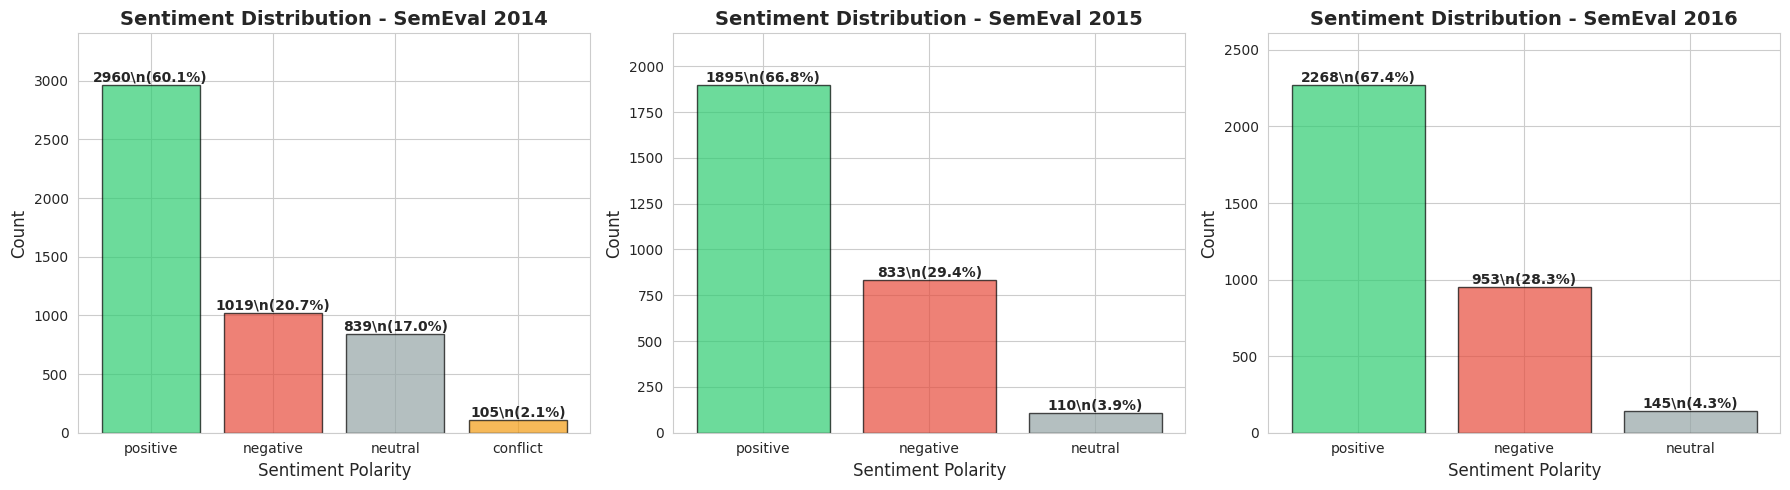

\n================================================================================
  SENTIMENT DISTRIBUTION STATISTICS
================================================================================\n
\n📊 2014 Dataset:
          Count  Percentage
polarity                   
positive   2960       60.13
negative   1019       20.70
neutral     839       17.04
conflict    105        2.13
\n⚖️  Imbalance Ratio (Max/Min): 28.19
------------------------------------------------------------
\n📊 2015 Dataset:
          Count  Percentage
polarity                   
positive   1895       66.77
negative    833       29.35
neutral     110        3.88
\n⚖️  Imbalance Ratio (Max/Min): 17.23
------------------------------------------------------------
\n📊 2016 Dataset:
          Count  Percentage
polarity                   
positive   2268       67.38
negative    953       28.31
neutral     145        4.31
\n⚖️  Imbalance Ratio (Max/Min): 15.64
---------------------------------------------------------

In [29]:
# Sentiment distribution for all datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (df_2014, '2014', axes[0]),
    (df_2015, '2015', axes[1]),
    (df_2016, '2016', axes[2])
]

for df, year, ax in datasets:
    plot_sentiment_distribution(df, f"SemEval {year}", ax)

plt.tight_layout()
plt.show()

# Print detailed statistics
print_section_header("SENTIMENT DISTRIBUTION STATISTICS")

for df, year in [(df_2014, '2014'), (df_2015, '2015'), (df_2016, '2016')]:
    print(f"\\n📊 {year} Dataset:")
    dist, imbalance = calculate_class_weights(df)
    print(dist)
    print(f"\\n⚖️  Imbalance Ratio (Max/Min): {imbalance:.2f}")
    print("-" * 60)



### 4.2 Top Aspects Analysis



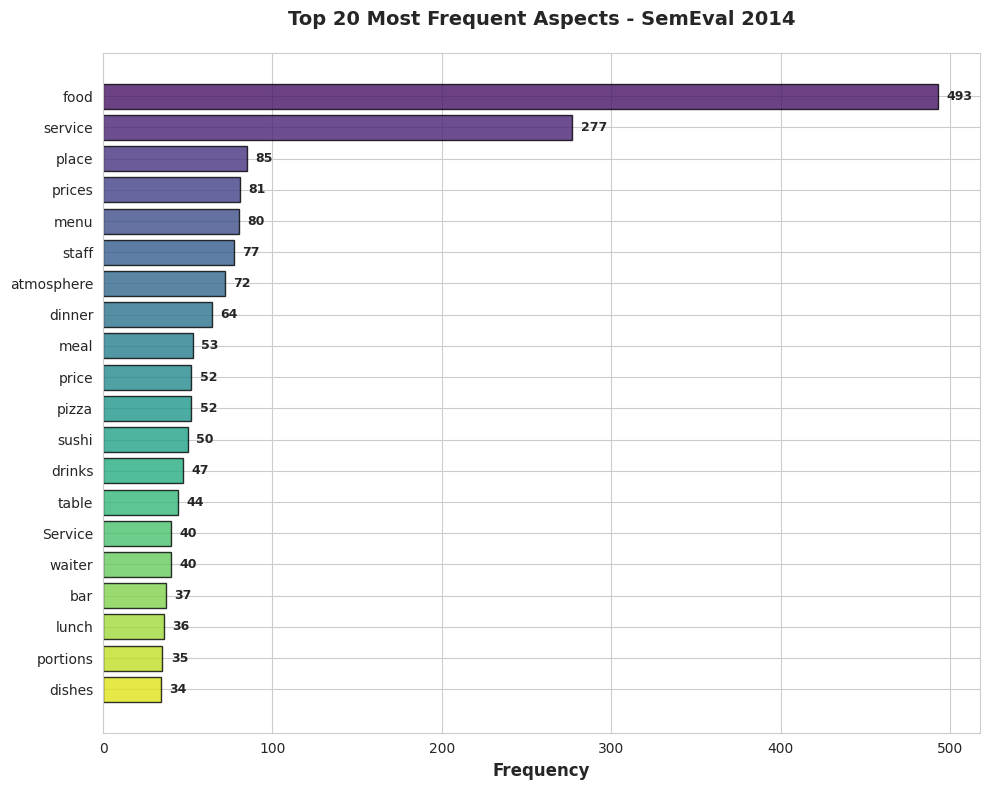

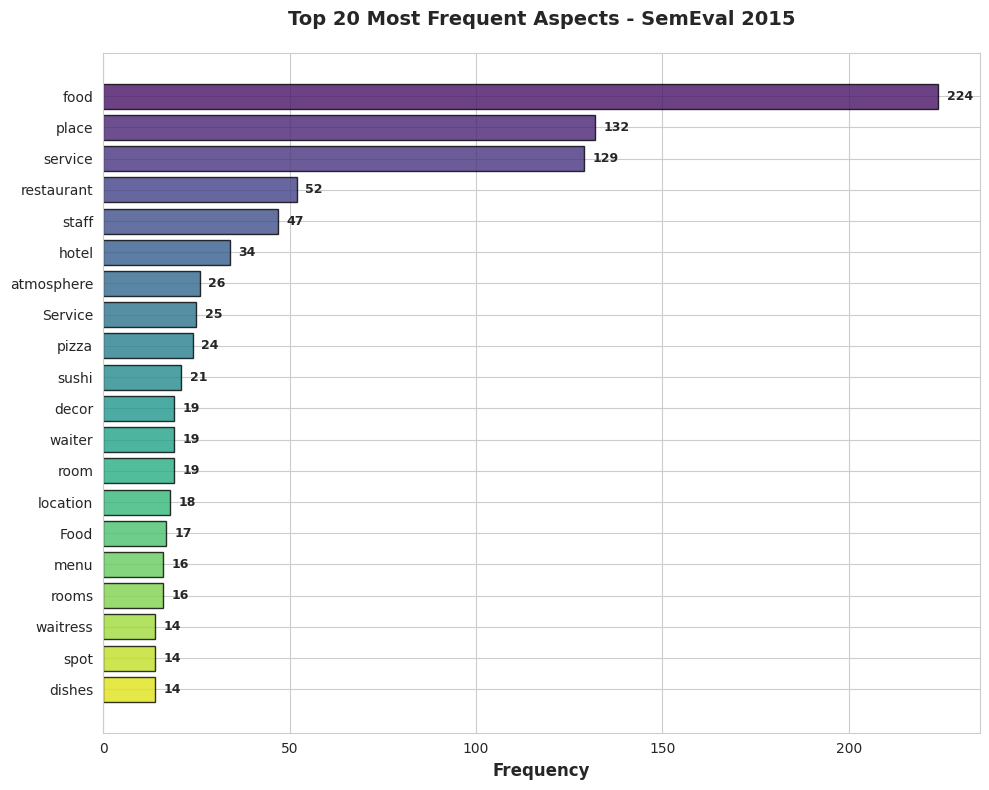

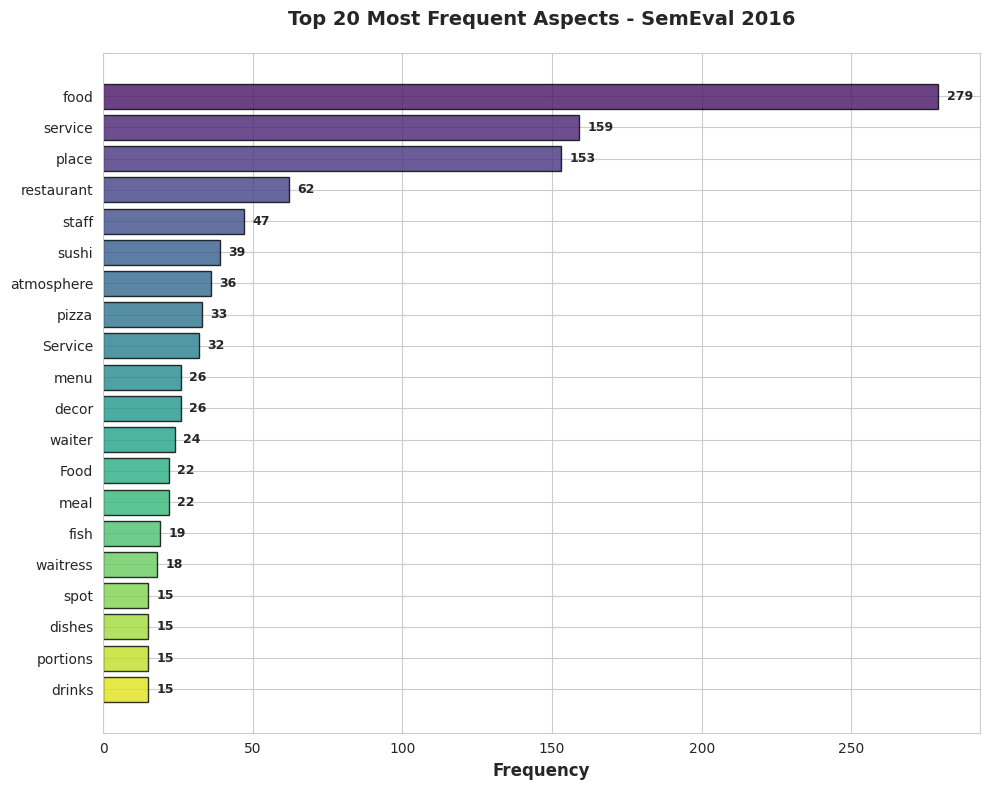

In [30]:
# Top 20 aspects for each dataset
def plot_top_aspects(df, dataset_name, top_n=20):
    """Plot top N aspects"""
    # Filter out implicit aspects
    explicit_df = df[df['aspect'] != '[ASPECT]']
    
    if len(explicit_df) == 0:
        print(f"No explicit aspects in {dataset_name}")
        return
    
    top_aspects = explicit_df['aspect'].value_counts().head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = sns.color_palette("viridis", top_n)
    bars = ax.barh(range(len(top_aspects)), top_aspects.values, color=colors, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, top_aspects.values)):
        ax.text(count + max(top_aspects.values)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{count}', va='center', fontweight='bold', fontsize=9)
    
    ax.set_yticks(range(len(top_aspects)))
    ax.set_yticklabels(top_aspects.index)
    ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Most Frequent Aspects - {dataset_name}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Plot for each dataset
plot_top_aspects(df_2014, "SemEval 2014", 20)
plot_top_aspects(df_2015, "SemEval 2015", 20)
plot_top_aspects(df_2016, "SemEval 2016", 20)



### 4.3 Sentence Length Distribution



In [31]:
# Calculate sentence statistics
def analyze_sentence_lengths(df, dataset_name):
    """Analyze sentence length distributions"""
    # Get unique sentences
    unique_sentences = df.drop_duplicates(subset='sentence_id')
    
    # Calculate lengths
    unique_sentences['sentence_length'] = unique_sentences['sentence'].str.len()
    unique_sentences['word_count'] = unique_sentences['sentence'].str.split().str.len()
    
    print_section_header(f"SENTENCE LENGTH ANALYSIS: {dataset_name}")
    
    print("📏 Character Length:")
    print(unique_sentences['sentence_length'].describe())
    
    print("\\n📝 Word Count:")
    print(unique_sentences['word_count'].describe())
    
    return unique_sentences

# Analyze each dataset
sent_2014 = analyze_sentence_lengths(df_2014, "SemEval 2014")
sent_2015 = analyze_sentence_lengths(df_2015, "SemEval 2015")
sent_2016 = analyze_sentence_lengths(df_2016, "SemEval 2016")



\n================================================================================
  SENTENCE LENGTH ANALYSIS: SemEval 2014
================================================================================\n
📏 Character Length:
count    2681.000000
mean       80.863484
std        43.324462
min        10.000000
25%        50.000000
50%        73.000000
75%       103.000000
max       357.000000
Name: sentence_length, dtype: float64
\n📝 Word Count:
count    2681.000000
mean       14.788512
std         7.946159
min         1.000000
25%         9.000000
50%        13.000000
75%        19.000000
max        69.000000
Name: word_count, dtype: float64
\n================================================================================
  SENTENCE LENGTH ANALYSIS: SemEval 2015
================================================================================\n
📏 Character Length:
count    1929.000000
mean       66.961638
std        43.702355
min         2.000000
25%        35.000000
50%        57.0000

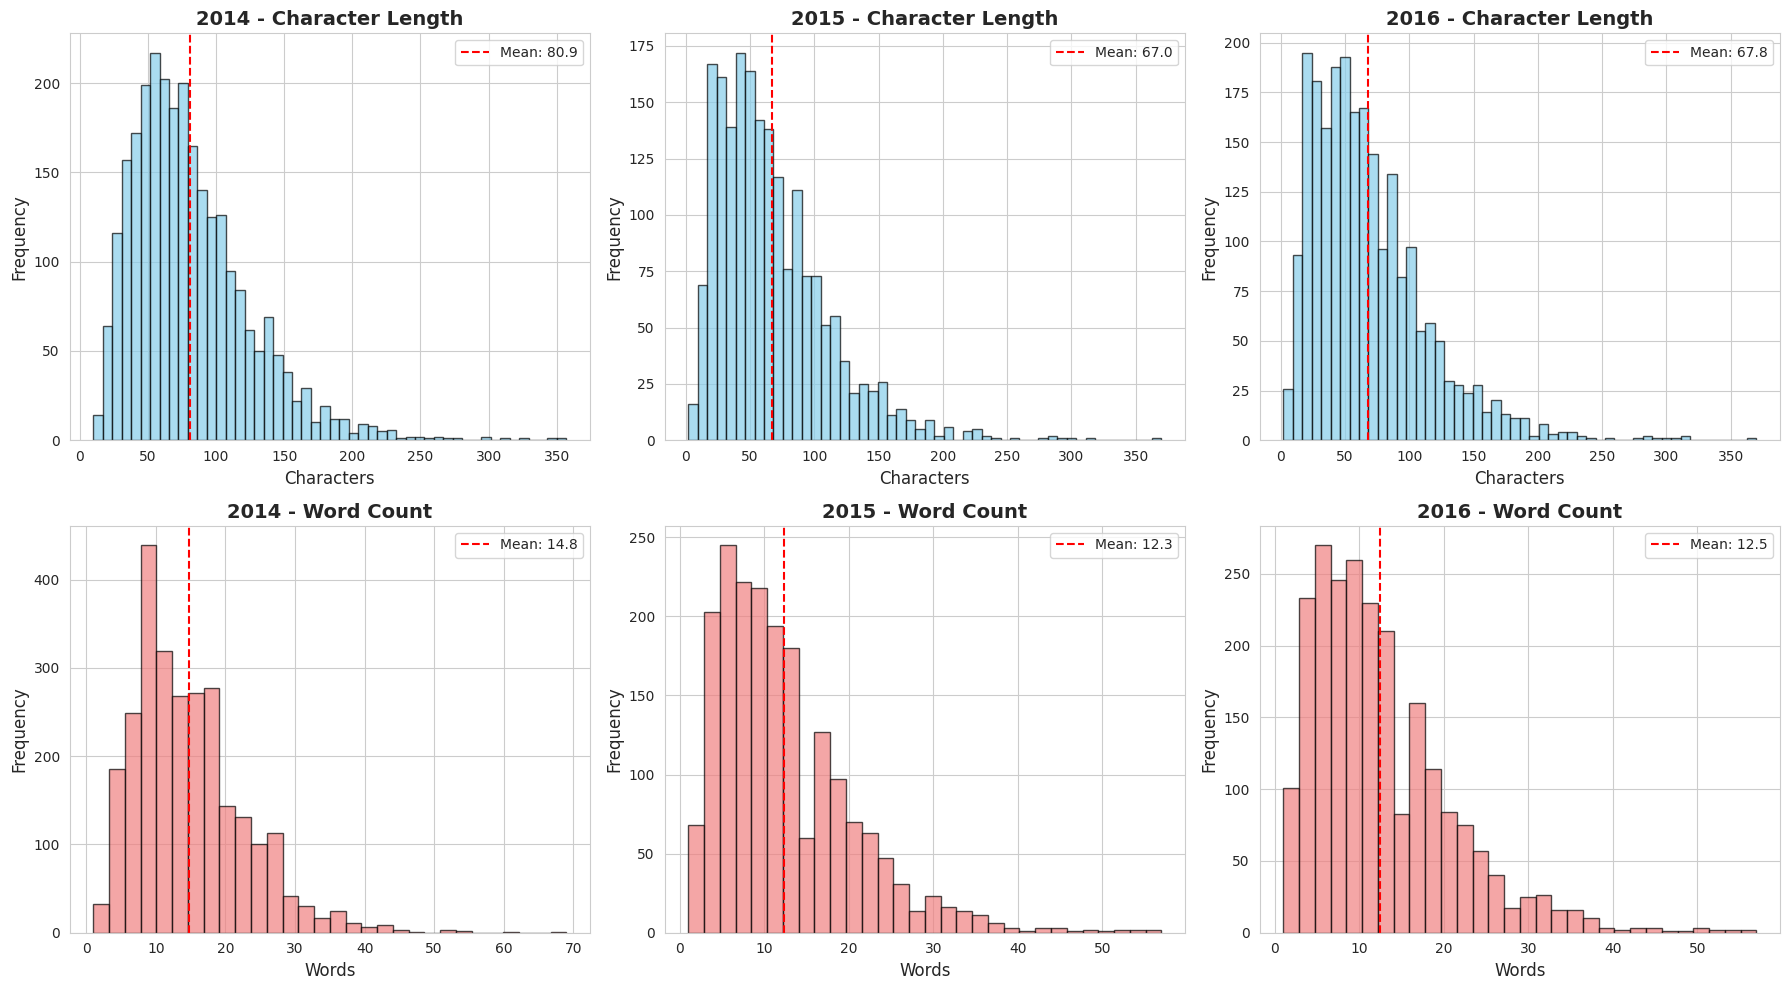

In [32]:
# Visualize sentence length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

datasets_sent = [
    (sent_2014, '2014', 0),
    (sent_2015, '2015', 1),
    (sent_2016, '2016', 2)
]

for sent_df, year, col in datasets_sent:
    # Character length histogram
    axes[0, col].hist(sent_df['sentence_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, col].set_title(f'{year} - Character Length', fontweight='bold')
    axes[0, col].set_xlabel('Characters')
    axes[0, col].set_ylabel('Frequency')
    axes[0, col].axvline(sent_df['sentence_length'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {sent_df["sentence_length"].mean():.1f}')
    axes[0, col].legend()
    
    # Word count histogram
    axes[1, col].hist(sent_df['word_count'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1, col].set_title(f'{year} - Word Count', fontweight='bold')
    axes[1, col].set_xlabel('Words')
    axes[1, col].set_ylabel('Frequency')
    axes[1, col].axvline(sent_df['word_count'].mean(), color='red', linestyle='--',
                         label=f'Mean: {sent_df["word_count"].mean():.1f}')
    axes[1, col].legend()

plt.tight_layout()
plt.show()



---
#
## 5️⃣ Bivariate Analysis
#
Exploring relationships between variables - sentiment by aspect, sentence length by sentiment, etc.



### 5.1 Sentiment Breakdown for Top Aspects



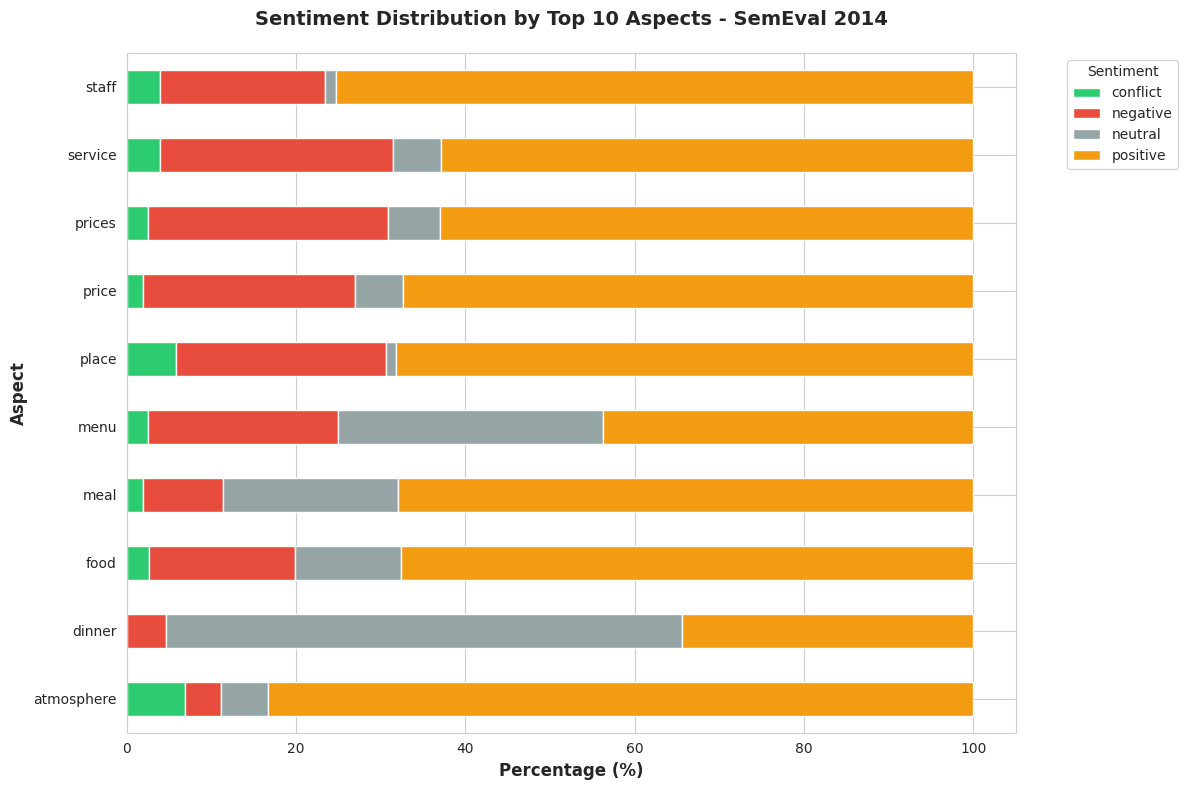

\n📊 Counts for SemEval 2014:
polarity    conflict  negative  neutral  positive
aspect                                           
atmosphere         5         3        4        60
dinner             0         3       39        22
food              13        85       62       333
meal               1         5       11        36
menu               2        18       25        35
place              5        21        1        58
price              1        13        3        35
prices             2        23        5        51
service           11        76       16       174
staff              3        15        1        58


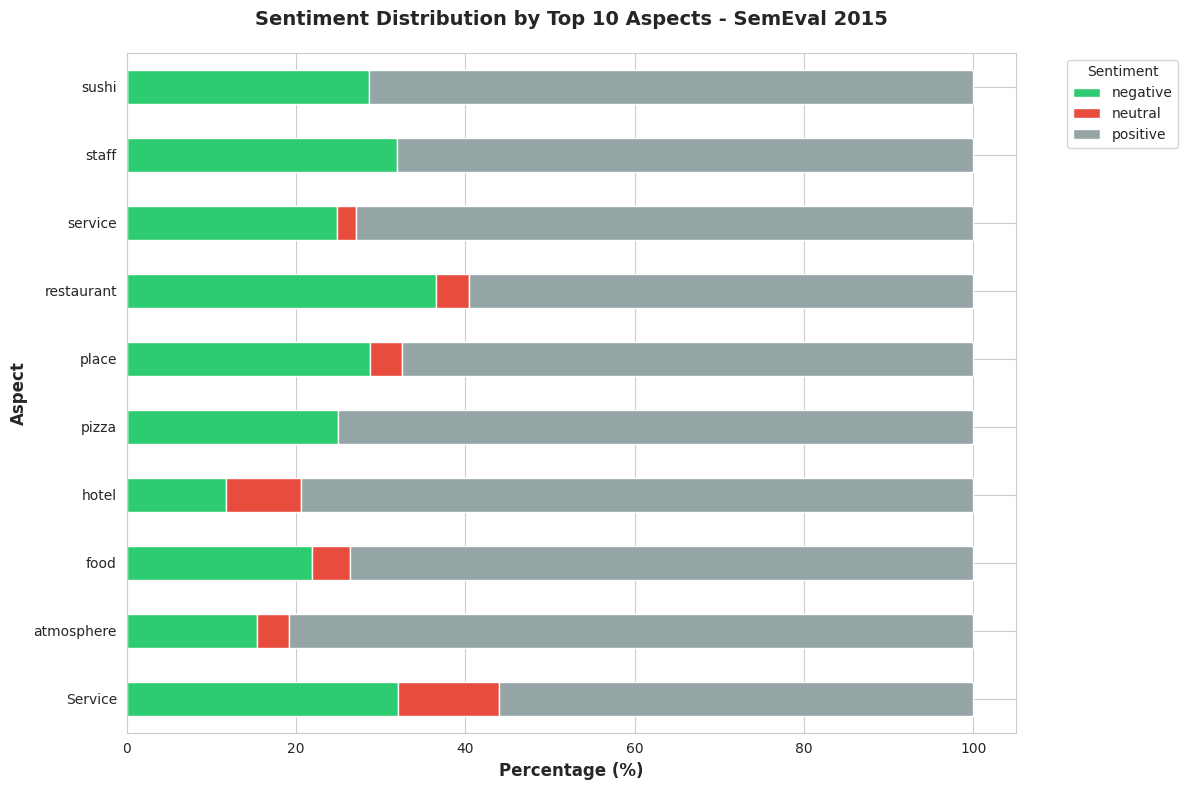

\n📊 Counts for SemEval 2015:
polarity    negative  neutral  positive
aspect                                 
Service            8        3        14
atmosphere         4        1        21
food              49       10       165
hotel              4        3        27
pizza              6        0        18
place             38        5        89
restaurant        19        2        31
service           32        3        94
staff             15        0        32
sushi              6        0        15


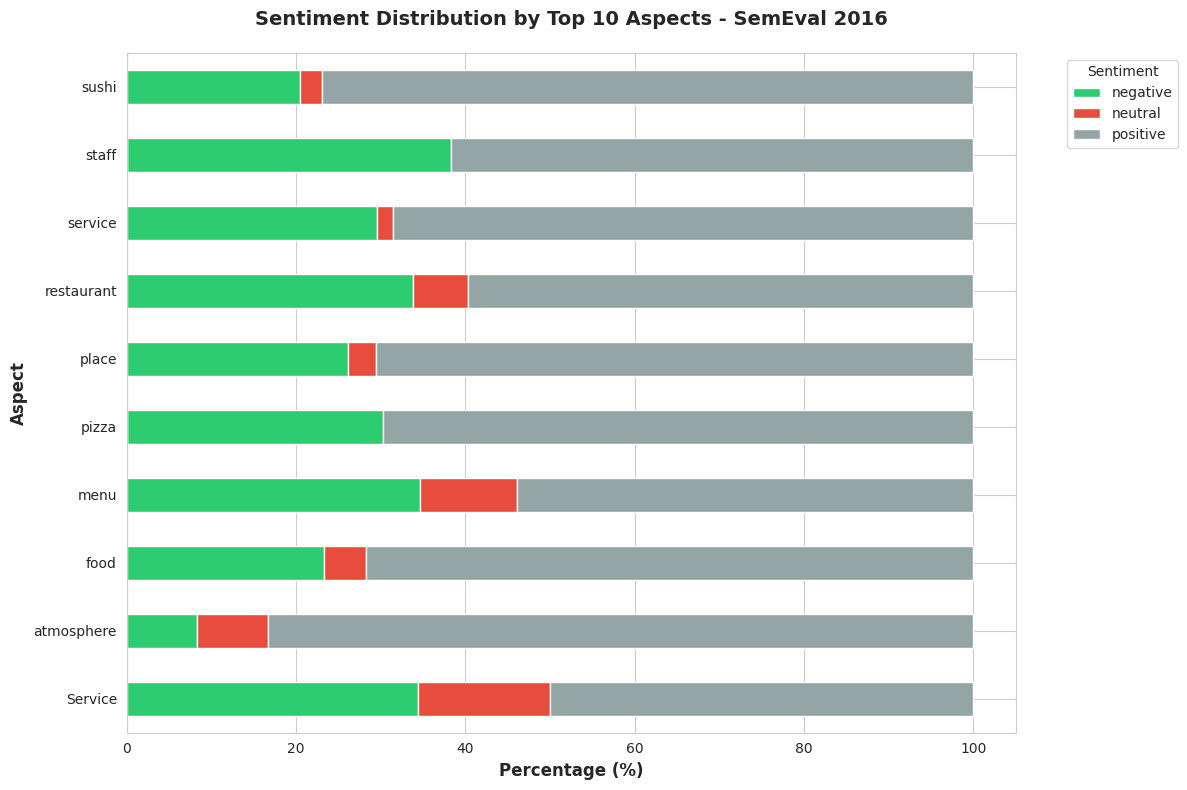

\n📊 Counts for SemEval 2016:
polarity    negative  neutral  positive
aspect                                 
Service           11        5        16
atmosphere         3        3        30
food              65       14       200
menu               9        3        14
pizza             10        0        23
place             40        5       108
restaurant        21        4        37
service           47        3       109
staff             18        0        29
sushi              8        1        30


In [33]:
# Sentiment distribution for top aspects
def plot_aspect_sentiment(df, dataset_name, top_n=10):
    """Plot sentiment breakdown for top N aspects"""
    # Get top aspects
    explicit_df = df[df['aspect'] != '[ASPECT]']
    top_aspects = explicit_df['aspect'].value_counts().head(top_n).index
    
    # Filter data
    filtered = explicit_df[explicit_df['aspect'].isin(top_aspects)]
    
    # Create crosstab
    ct = pd.crosstab(filtered['aspect'], filtered['polarity'], normalize='index') * 100
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ct.plot(kind='barh', stacked=True, ax=ax, 
            color=['#2ecc71', '#e74c3c', '#95a5a6', '#f39c12'])
    
    ax.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Aspect', fontsize=12, fontweight='bold')
    ax.set_title(f'Sentiment Distribution by Top {top_n} Aspects - {dataset_name}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print raw counts
    print(f"\\n📊 Counts for {dataset_name}:")
    print(pd.crosstab(filtered['aspect'], filtered['polarity']))

plot_aspect_sentiment(df_2014, "SemEval 2014", 10)
plot_aspect_sentiment(df_2015, "SemEval 2015", 10)
plot_aspect_sentiment(df_2016, "SemEval 2016", 10)



### 5.2 Sentence Length vs Sentiment



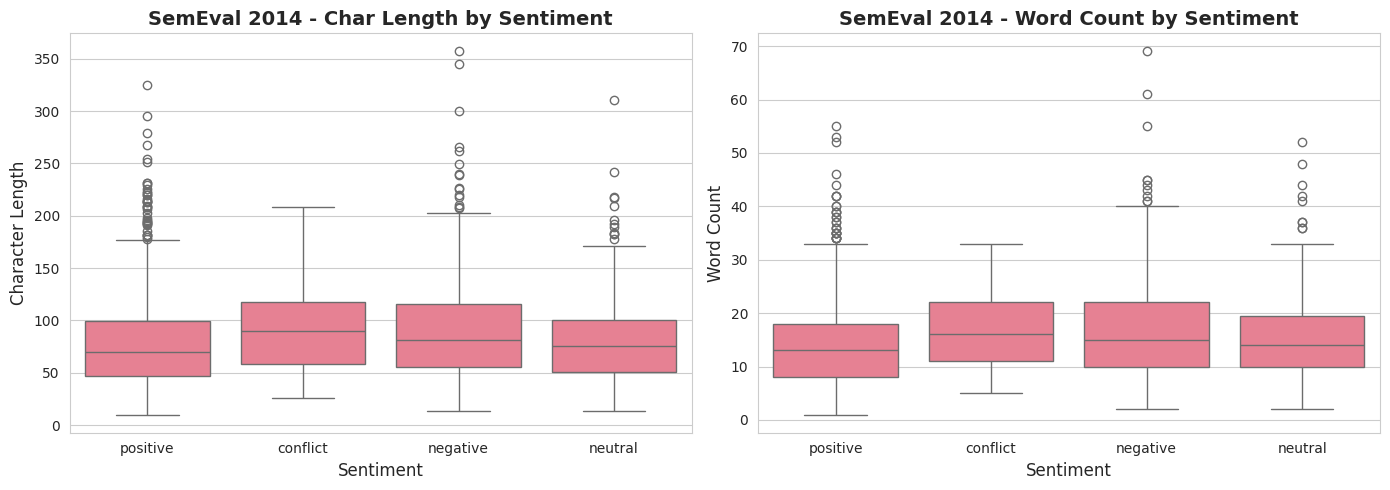

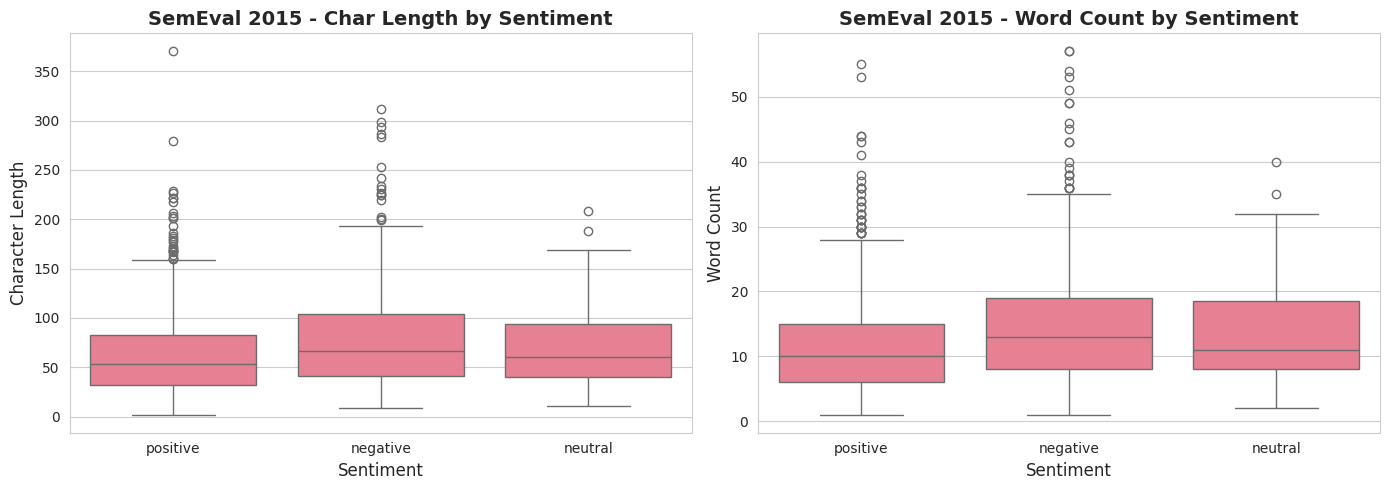

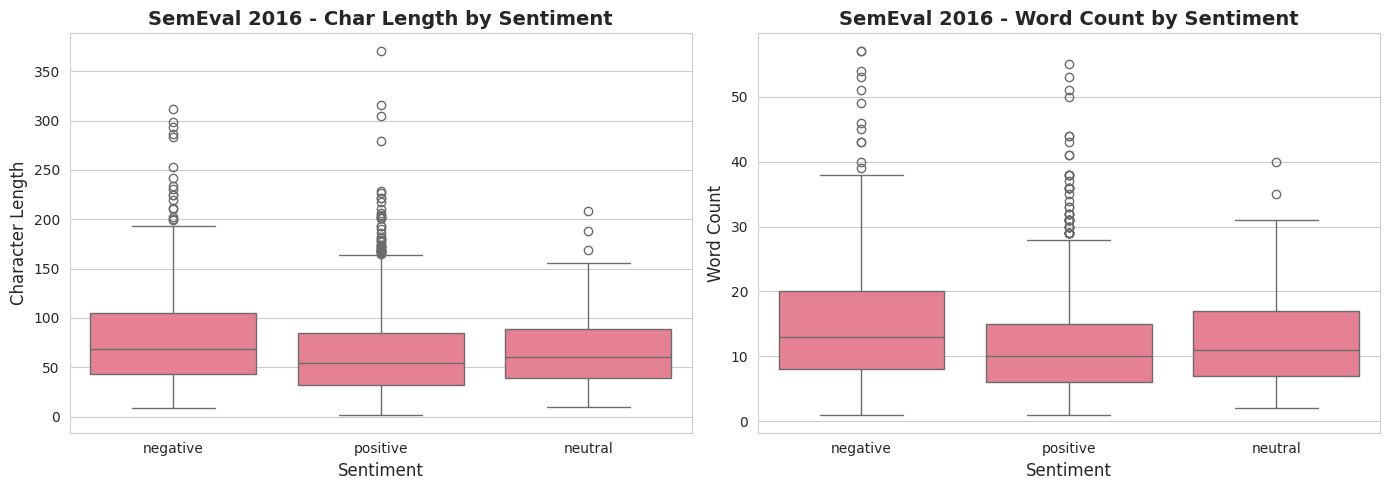

In [34]:
# Sentence length by sentiment
def plot_length_by_sentiment(sent_df, df, dataset_name):
    """Box plot of sentence length by sentiment"""
    # Merge to get polarity for each unique sentence
    # Take the first occurrence of each sentence_id
    polarity_map = df.drop_duplicates('sentence_id')[['sentence_id', 'polarity']].copy()
    
    # Ensure sent_df has the columns we need
    sent_df_copy = sent_df[['sentence_id', 'sentence_length', 'word_count']].copy()
    
    # Merge
    sent_with_pol = sent_df_copy.merge(polarity_map, on='sentence_id', how='inner')
    
    # Debug: check if polarity column exists
    if 'polarity' not in sent_with_pol.columns:
        print(f"ERROR: polarity column missing. Available columns: {sent_with_pol.columns.tolist()}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Character length - use seaborn for more robust plotting
    import seaborn as sns
    sns.boxplot(data=sent_with_pol, x='polarity', y='sentence_length', ax=axes[0])
    axes[0].set_title(f'{dataset_name} - Char Length by Sentiment', fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Character Length')
    
    # Word count
    sns.boxplot(data=sent_with_pol, x='polarity', y='word_count', ax=axes[1])
    axes[1].set_title(f'{dataset_name} - Word Count by Sentiment', fontweight='bold')
    axes[1].set_xlabel('Sentiment')
    axes[1].set_ylabel('Word Count')
    
    plt.tight_layout()
    plt.show()

plot_length_by_sentiment(sent_2014, df_2014, "SemEval 2014")
plot_length_by_sentiment(sent_2015, df_2015, "SemEval 2015")
plot_length_by_sentiment(sent_2016, df_2016, "SemEval 2016")


### 5.3 Aspect Count per Sentence



\n📊 2014 - Aspect Count Distribution:
count    2681.000000
mean        1.836255
std         1.109510
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        13.000000
dtype: float64
\n📊 2015 - Aspect Count Distribution:
count    1929.000000
mean        1.471229
std         0.815009
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
dtype: float64
\n📊 2016 - Aspect Count Distribution:
count    2295.000000
mean        1.466667
std         0.945139
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        26.000000
dtype: float64


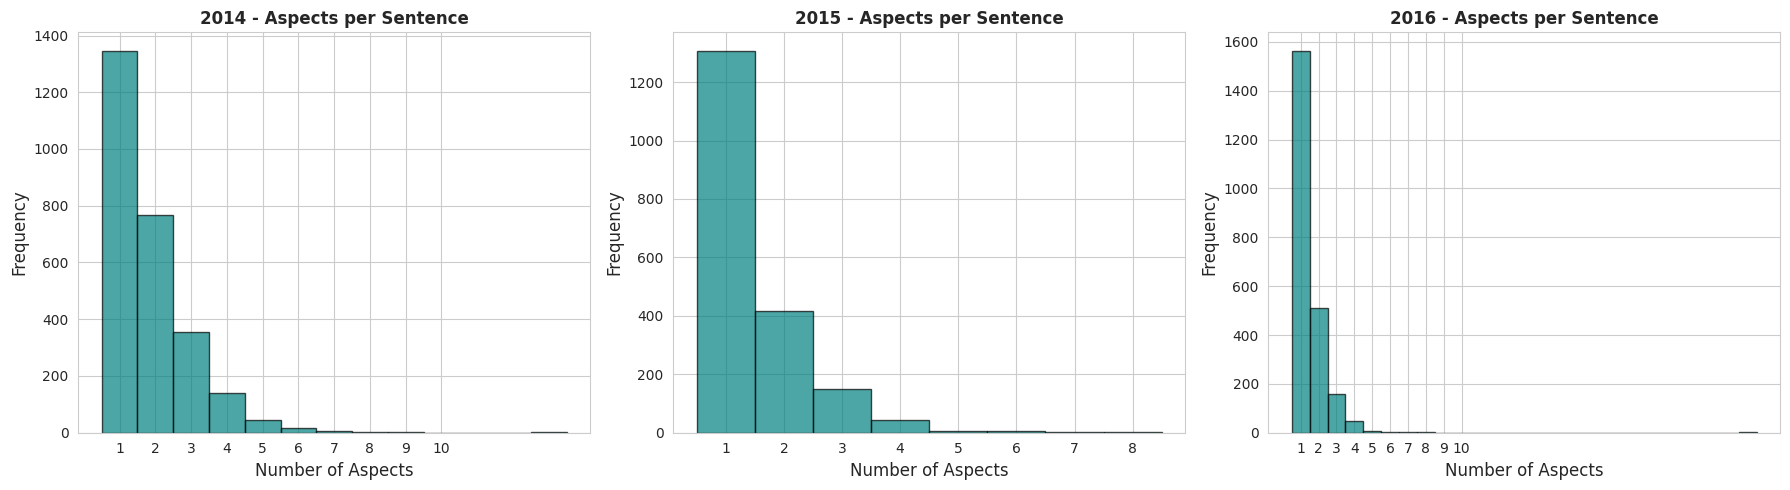

In [35]:
# Distribution of aspect counts per sentence
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df, year) in enumerate([(df_2014, '2014'), (df_2015, '2015'), (df_2016, '2016')]):
    aspect_counts = df.groupby('sentence_id').size()
    
    axes[idx].hist(aspect_counts, bins=range(1, aspect_counts.max()+2), 
                   color='teal', edgecolor='black', alpha=0.7, align='left')
    axes[idx].set_title(f'{year} - Aspects per Sentence', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Number of Aspects')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xticks(range(1, min(11, aspect_counts.max()+1)))
    
    print(f"\\n📊 {year} - Aspect Count Distribution:")
    print(aspect_counts.describe())

plt.tight_layout()
plt.show()



---
#
## 6️⃣ T ext & NLP Analysis
#
Advanced text analysis including word clouds, n-grams, and vocabulary statistics.



### 6.1 Word Clouds



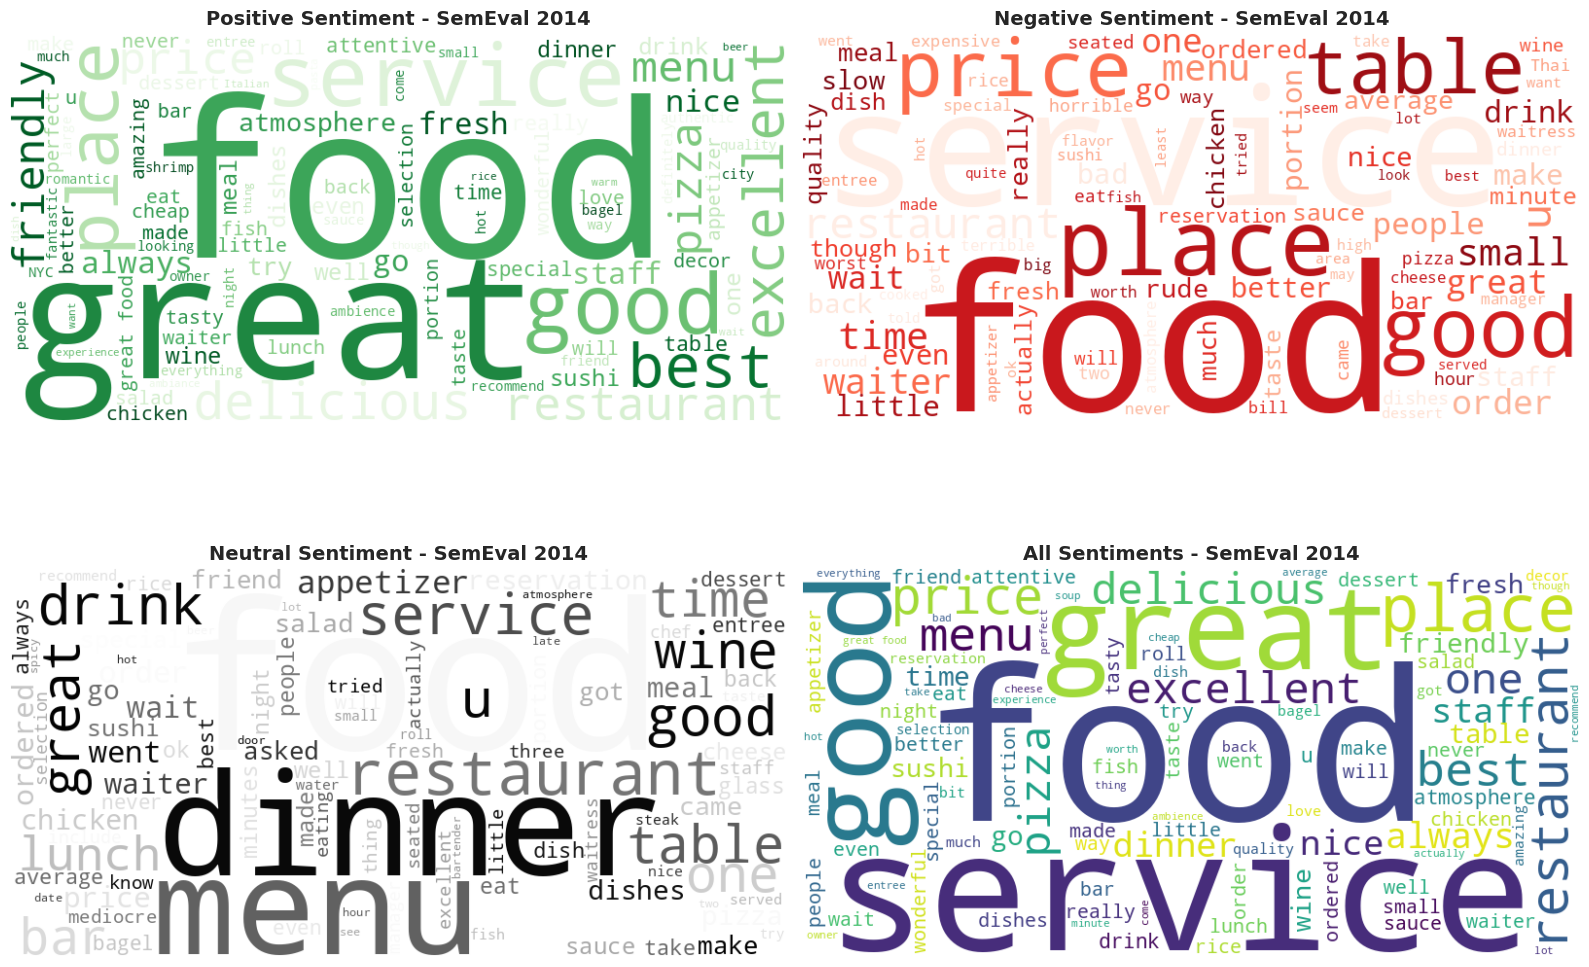

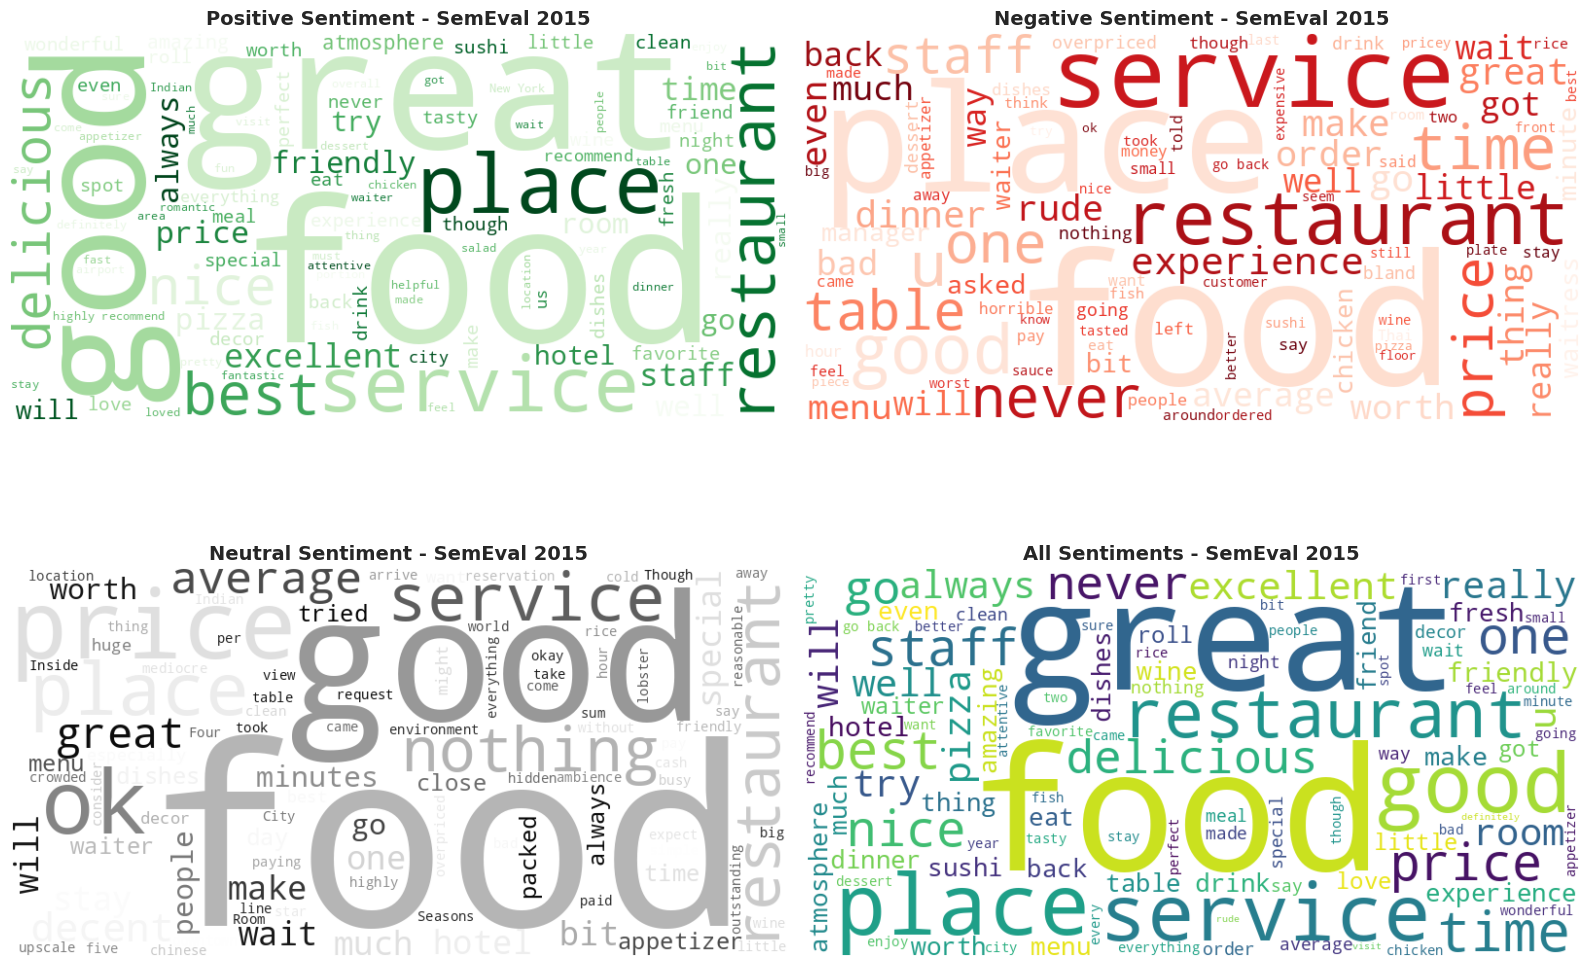

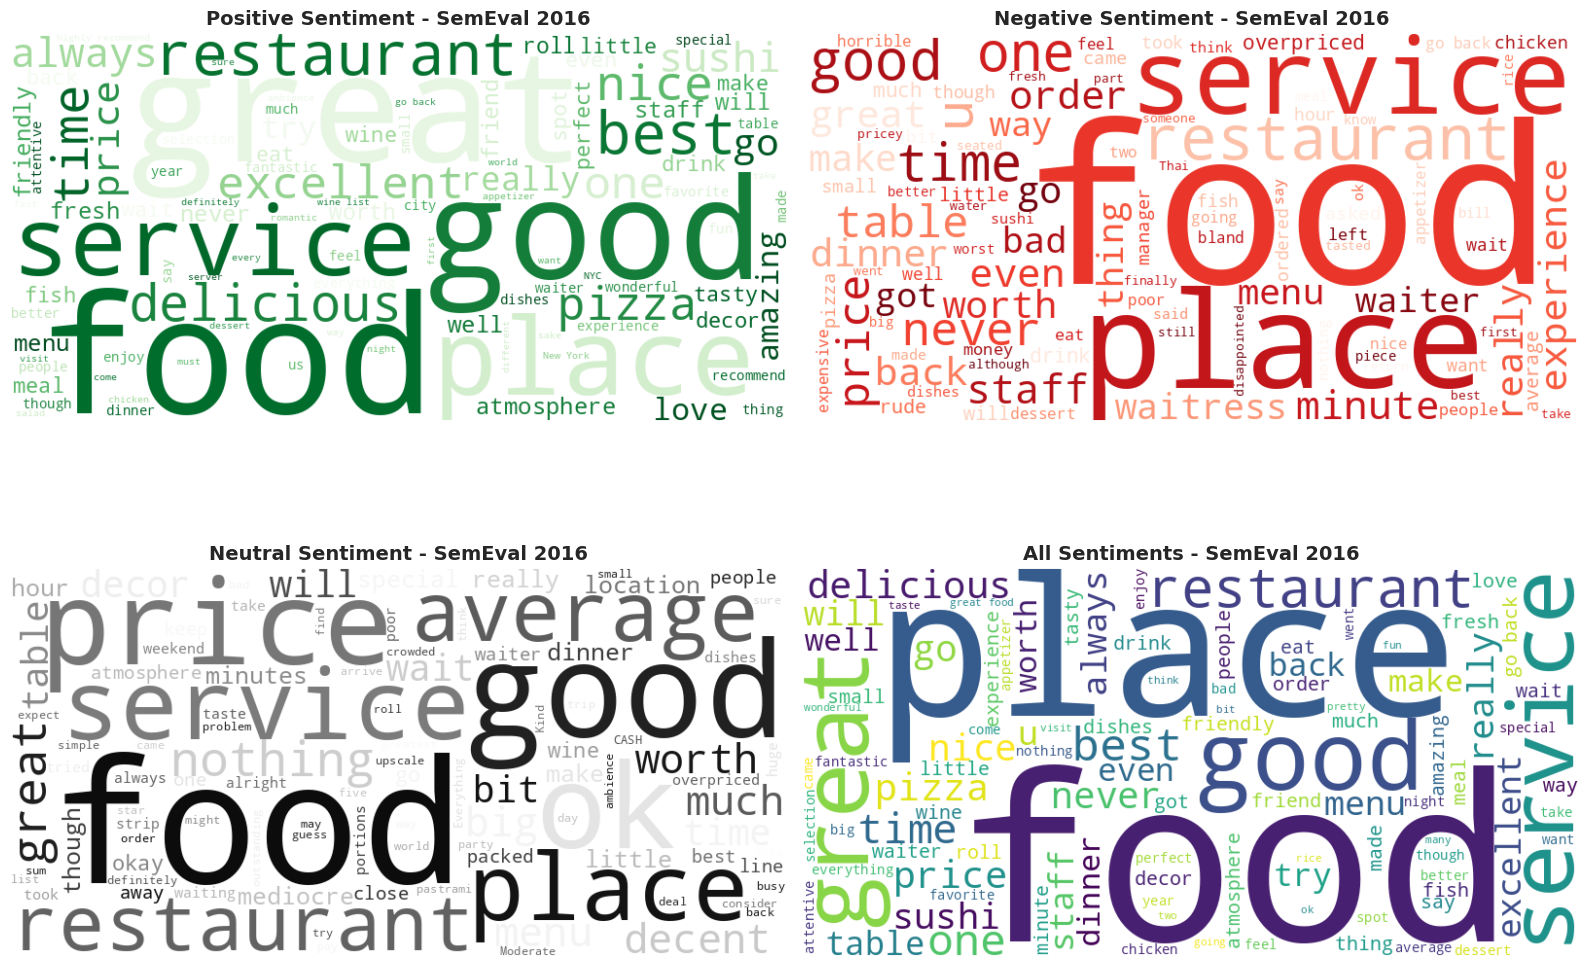

In [36]:
# Generate word clouds for sentiments
if WORDCLOUD_AVAILABLE:
    def generate_wordclouds(df, dataset_name):
        """Generate word clouds for different sentiments"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        sentiments = ['positive', 'negative', 'neutral', 'all']
        colors = ['Greens', 'Reds', 'Greys', 'viridis']
        
        for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors)):
            if sentiment == 'all':
                text = ' '.join(df['sentence'].unique())
                title = 'All Sentiments'
            else:
                subset = df[df['polarity'] == sentiment]
                if len(subset) == 0:
                    axes[idx].text(0.5, 0.5, f'No {sentiment} samples', 
                                  ha='center', va='center', fontsize=14)
                    axes[idx].axis('off')
                    continue
                text = ' '.join(subset['sentence'].unique())
                title = f'{sentiment.capitalize()} Sentiment'
            
            # Generate word cloud
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 colormap=cmap, max_words=100, relative_scaling=0.5).generate(text)
            
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{title} - {dataset_name}', fontsize=14, fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    generate_wordclouds(df_2014, "SemEval 2014")
    generate_wordclouds(df_2015, "SemEval 2015")
    generate_wordclouds(df_2016, "SemEval 2016")
else:
    print("⚠️ WordCloud library not available. Skipping word cloud generation.")



### 6.2 N-gram Analysis



\n================================================================================
  BIGRAM ANALYSIS
================================================================================\n


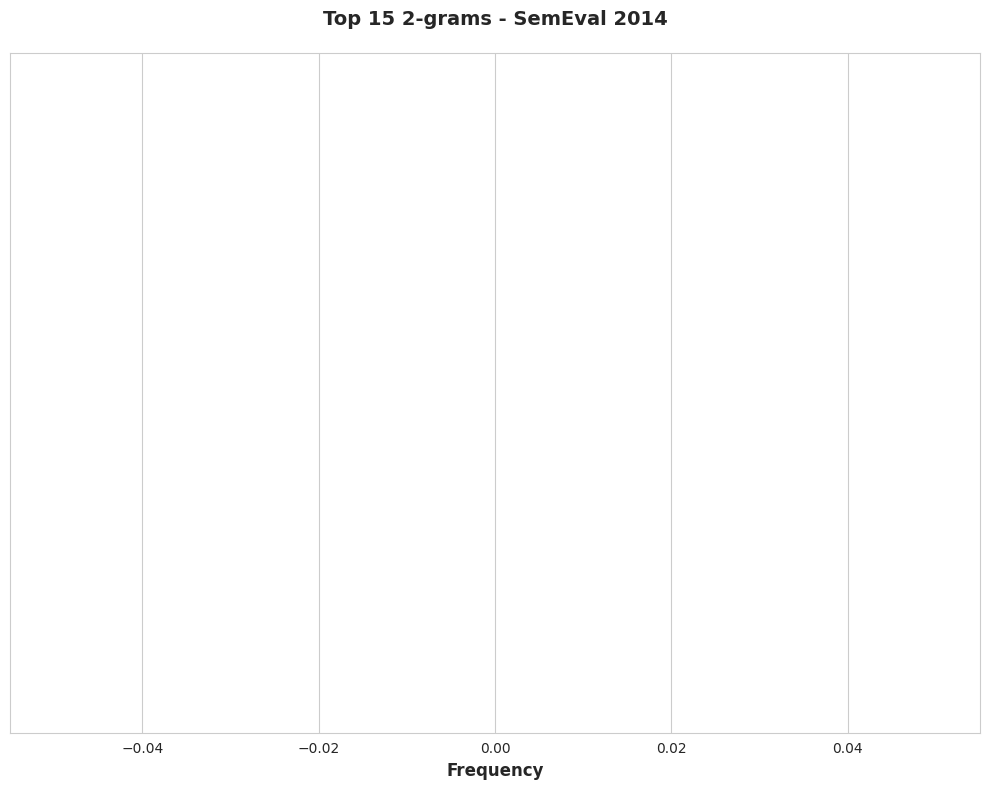

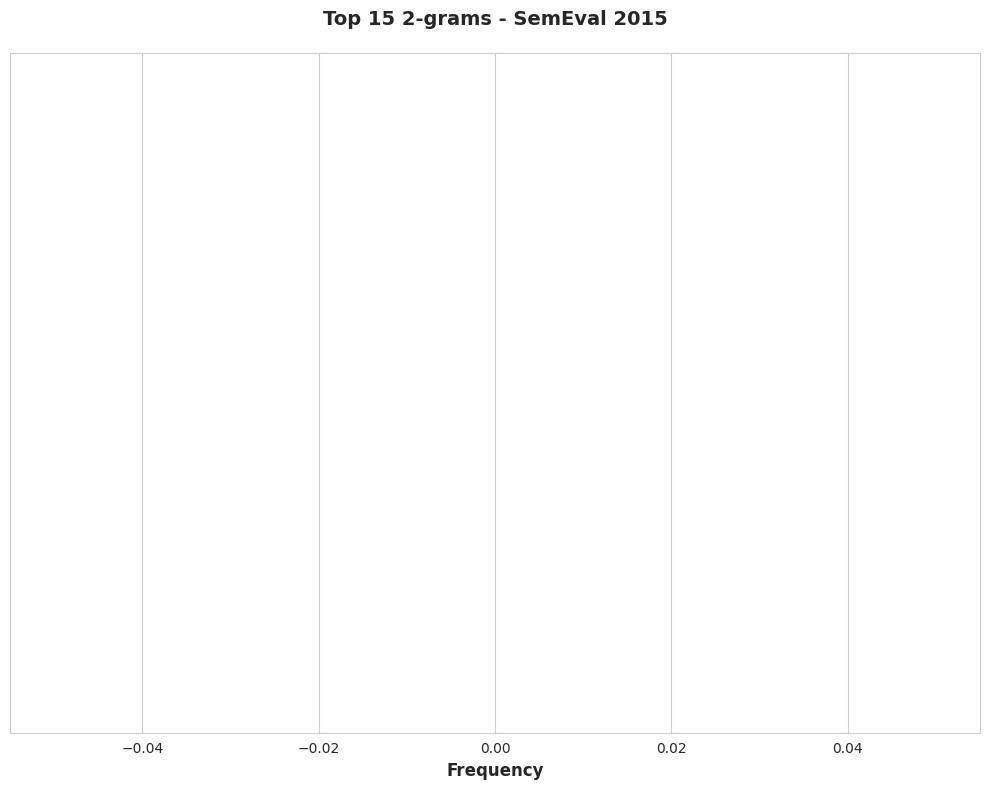

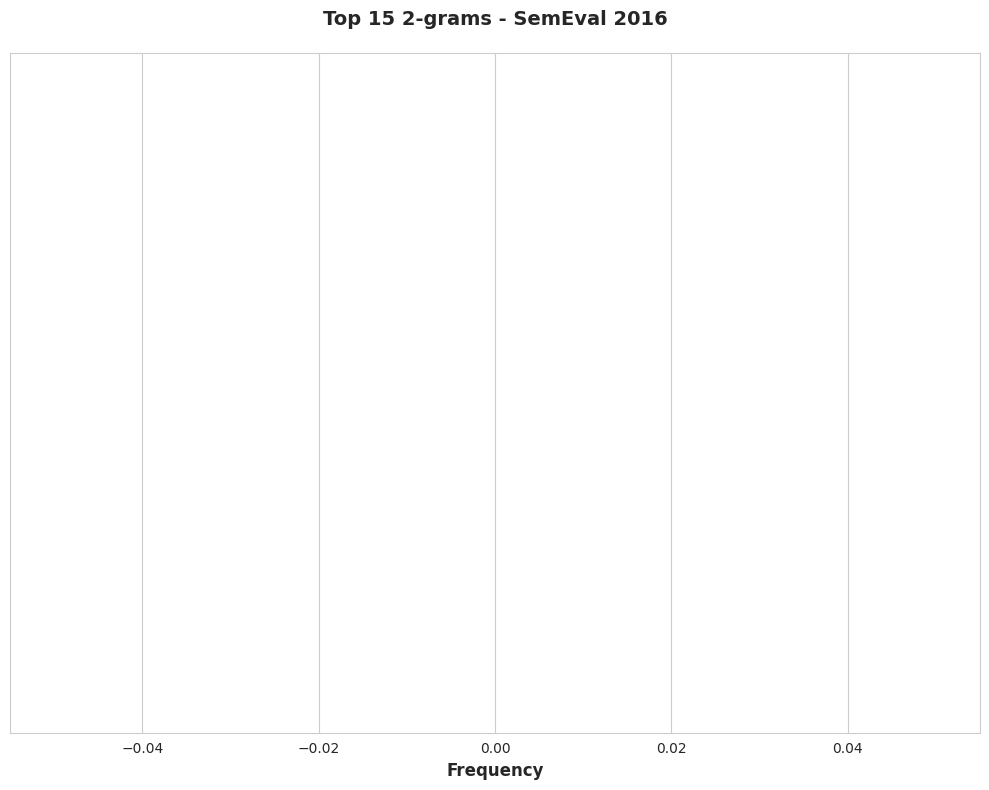

\n================================================================================
  TRIGRAM ANALYSIS
================================================================================\n


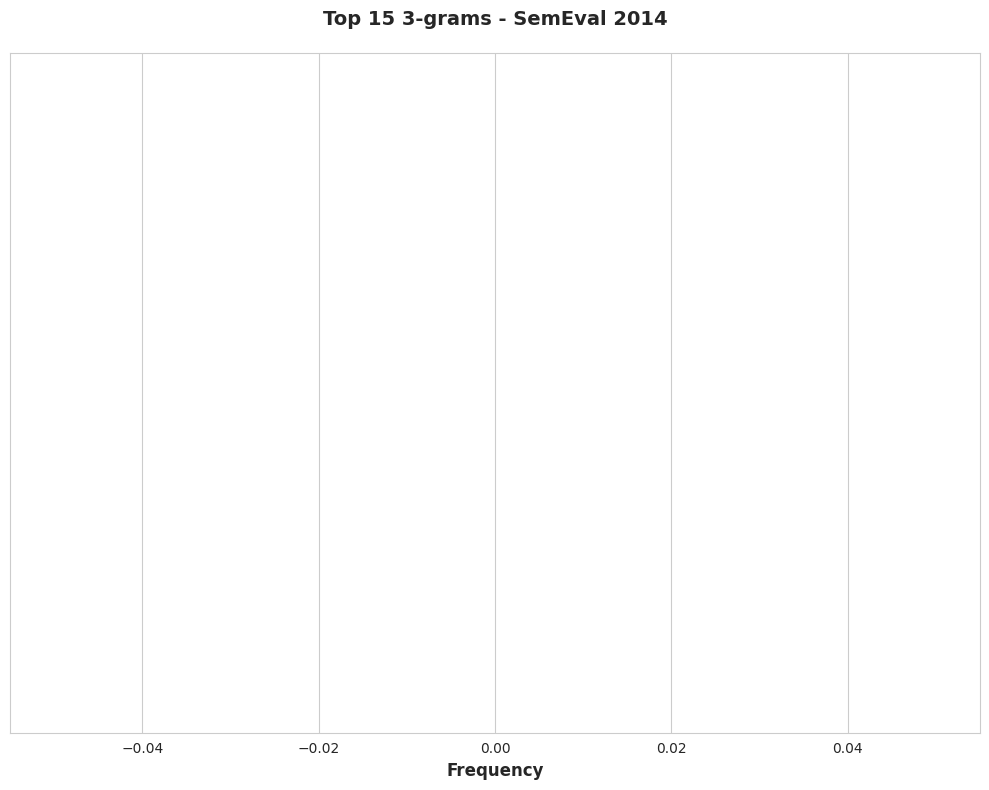

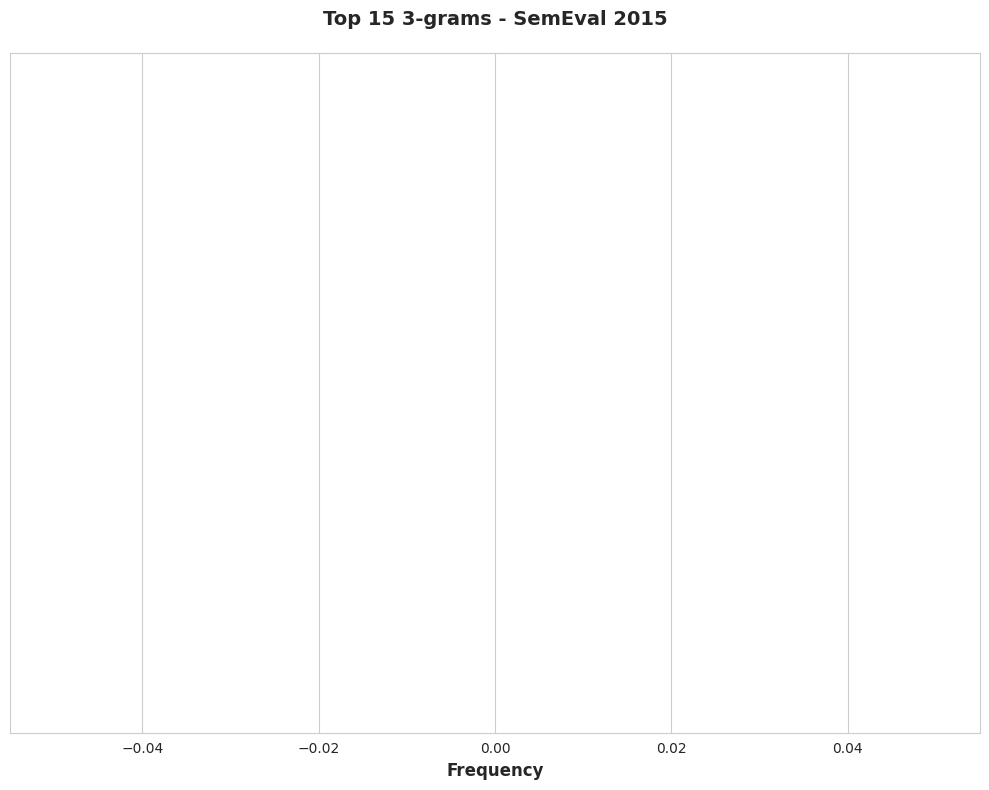

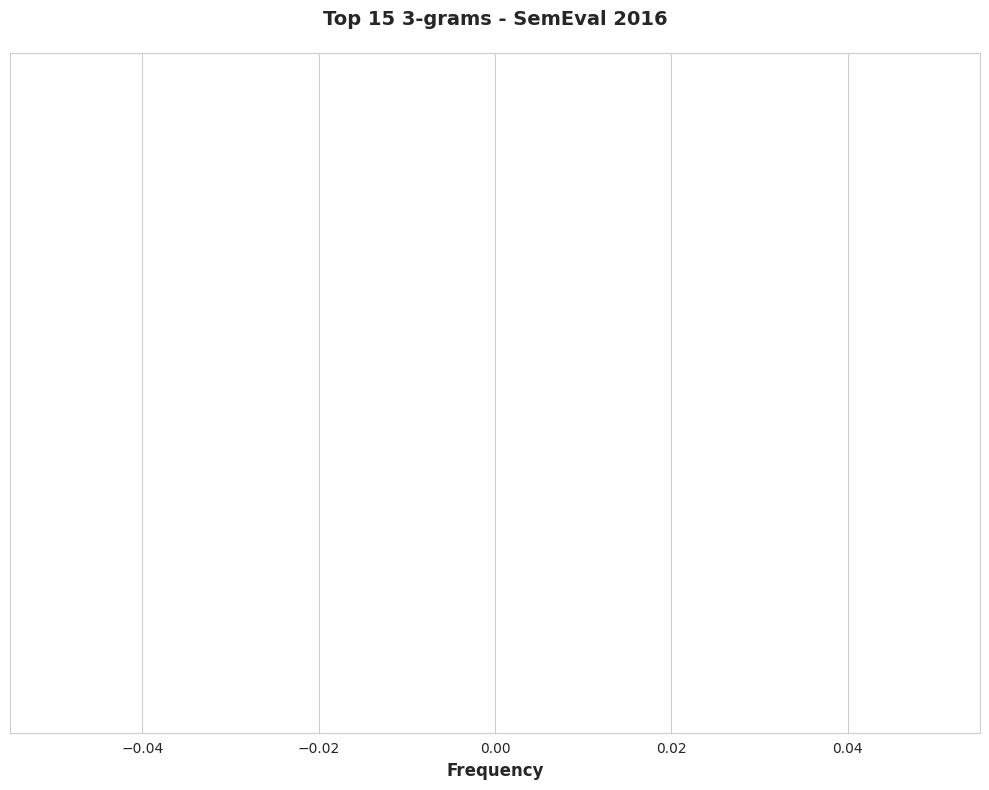

In [37]:
# N-gram analysis
if NLTK_AVAILABLE:
    def analyze_ngrams(df, dataset_name, n=2, top_k=15):
        """Analyze and visualize top n-grams"""
        # Get unique sentences
        sentences = df['sentence'].unique()
        
        # Tokenize and create n-grams
        all_ngrams = []
        for sent in sentences:
            # Simple tokenization (lowercase, remove punctuation)
            tokens = re.findall(r'\\b\\w+\\b', sent.lower())
            all_ngrams.extend(list(ngrams(tokens, n)))
        
        # Count and get top k
        ngram_counts = Counter(all_ngrams)
        top_ngrams = ngram_counts.most_common(top_k)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        
        ngram_labels = [' '.join(ng) for ng, _ in top_ngrams]
        ngram_values = [count for _, count in top_ngrams]
        
        colors = sns.color_palette("rocket", top_k)
        bars = ax.barh(range(len(ngram_labels)), ngram_values, color=colors, edgecolor='black', alpha=0.8)
        
        # Add value labels
        for i, (bar, count) in enumerate(zip(bars, ngram_values)):
            ax.text(count + max(ngram_values)*0.01, bar.get_y() + bar.get_height()/2,
                    f'{count}', va='center', fontweight='bold', fontsize=9)
        
        ax.set_yticks(range(len(ngram_labels)))
        ax.set_yticklabels(ngram_labels)
        ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title(f'Top {top_k} {n}-grams - {dataset_name}', fontsize=14, fontweight='bold', pad=20)
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    # Bigrams
    print_section_header("BIGRAM ANALYSIS")
    analyze_ngrams(df_2014, "SemEval 2014", n=2, top_k=15)
    analyze_ngrams(df_2015, "SemEval 2015", n=2, top_k=15)
    analyze_ngrams(df_2016, "SemEval 2016", n=2, top_k=15)
    
    # Trigrams
    print_section_header("TRIGRAM ANALYSIS")
    analyze_ngrams(df_2014, "SemEval 2014", n=3, top_k=15)
    analyze_ngrams(df_2015, "SemEval 2015", n=3, top_k=15)
    analyze_ngrams(df_2016, "SemEval 2016", n=3, top_k=15)
else:
    print("⚠️ NLTK library not available. Skipping n-gram analysis.")



### 6.3 Vocabulary Richness



In [38]:
# Vocabulary statistics
def vocabulary_stats(df, dataset_name):
    """Calculate vocabulary richness metrics"""
    print_section_header(f"VOCABULARY STATISTICS: {dataset_name}")
    
    unique_sentences = df['sentence'].unique()
    all_text = ' '.join(unique_sentences)
    
    # Tokenize
    tokens = re.findall(r'\\b\\w+\\b', all_text.lower())
    
    # Calculate metrics
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    type_token_ratio = unique_tokens / total_tokens if total_tokens > 0 else 0
    
    print(f"📝 Total Tokens: {total_tokens:,}")
    print(f"🌟 Unique Tokens (Vocabulary Size): {unique_tokens:,}")
    print(f"📊 Type-Token Ratio (TTR): {type_token_ratio:.4f}")
    print(f"📏 Average Token Length: {np.mean([len(t) for t in tokens]):.2f} characters")
    
    # Most common words
    word_counts = Counter(tokens)
    print(f"\\n🔝 Top 20 Most Frequent Words:")
    for word, count in word_counts.most_common(20):
        print(f"  {word}: {count}")
    
    print("\\n" + "-"*80)

vocabulary_stats(df_2014, "SemEval 2014")
vocabulary_stats(df_2015, "SemEval 2015")
vocabulary_stats(df_2016, "SemEval 2016")



\n================================================================================
  VOCABULARY STATISTICS: SemEval 2014
================================================================================\n
📝 Total Tokens: 0
🌟 Unique Tokens (Vocabulary Size): 0
📊 Type-Token Ratio (TTR): 0.0000
📏 Average Token Length: nan characters
\n🔝 Top 20 Most Frequent Words:
\n--------------------------------------------------------------------------------
\n================================================================================
  VOCABULARY STATISTICS: SemEval 2015
================================================================================\n
📝 Total Tokens: 0
🌟 Unique Tokens (Vocabulary Size): 0
📊 Type-Token Ratio (TTR): 0.0000
📏 Average Token Length: nan characters
\n🔝 Top 20 Most Frequent Words:
\n--------------------------------------------------------------------------------
\n================================================================================
  VOCABULARY STATISTICS: 

---
#
## 7️⃣ Cross-Dataset Comparison
#
Comparing characteristics across all three datasets to identify similarities and differences.



In [39]:
# Create comparison summary table
print_section_header("CROSS-DATASET COMPARISON SUMMARY")

comparison_data = []

for df, year in [(df_2014, '2014'), (df_2015, '2015'), (df_2016, '2016')]:
    unique_sentences = df['sentence_id'].nunique()
    total_aspects = len(df)
    unique_aspects = df[df['aspect'] != '[ASPECT]']['aspect'].nunique()
    implicit = (df['aspect'] == '[ASPECT]').sum()
    
    # Sentiment distribution
    sent_dist = df['polarity'].value_counts()
    
    comparison_data.append({
        'Dataset': f'SemEval {year}',
        'Unique Sentences': unique_sentences,
        'Total Aspects': total_aspects,
        'Avg Aspects/Sentence': round(total_aspects/unique_sentences, 2),
        'Unique Explicit Aspects': unique_aspects,
        'Implicit Aspects': implicit,
        'Positive': sent_dist.get('positive', 0),
        'Negative': sent_dist.get('negative', 0),
        'Neutral': sent_dist.get('neutral', 0),
        'Conflict': sent_dist.get('conflict', 0)
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)



\n================================================================================
  CROSS-DATASET COMPARISON SUMMARY
================================================================================\n


Dataset  Unique Sentences  Total Aspects  Avg Aspects/Sentence  \
0  SemEval 2014              2681           4923                  1.84   
1  SemEval 2015              1929           2838                  1.47   
2  SemEval 2016              2295           3366                  1.47   

   Unique Explicit Aspects  Implicit Aspects  Positive  Negative  Neutral  \
0                     1651                 0      2960      1019      839   
1                      796               698      1895       833      110   
2                      945               836      2268       953      145   

   Conflict  
0       105  
1         0  
2         0

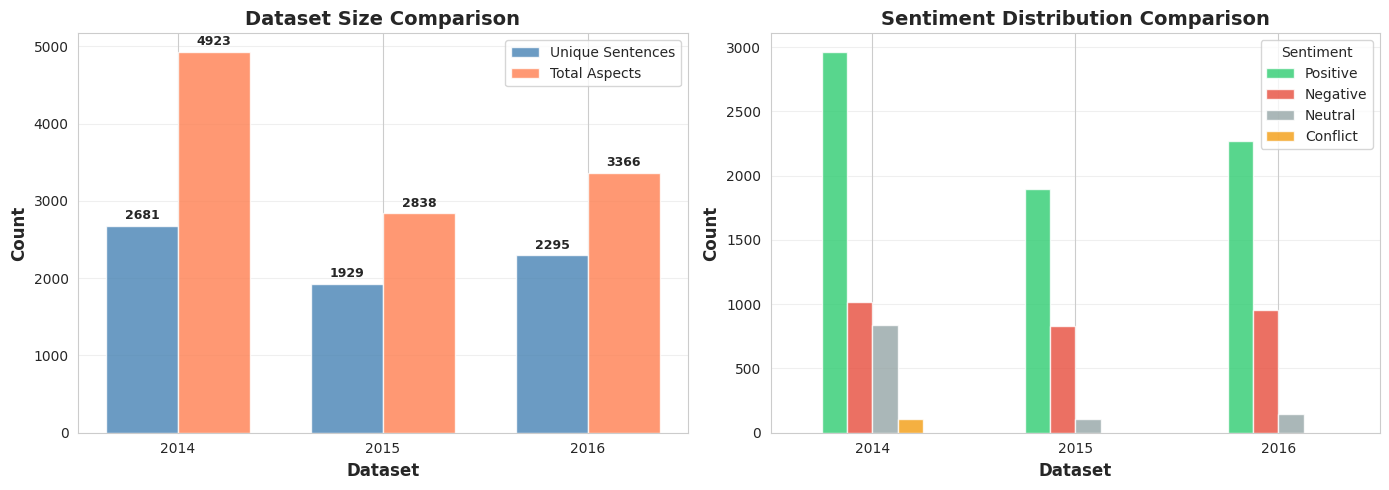

In [40]:
# Visualize dataset size comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

datasets = ['2014', '2015', '2016']
sentences = [comparison_df.iloc[i]['Unique Sentences'] for i in range(3)]
aspects = [comparison_df.iloc[i]['Total Aspects'] for i in range(3)]

x = np.arange(len(datasets))
width = 0.35

axes[0].bar(x - width/2, sentences, width, label='Unique Sentences', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, aspects, width, label='Total Aspects', color='coral', alpha=0.8)
axes[0].set_xlabel('Dataset', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Dataset Size Comparison', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (s, a) in enumerate(zip(sentences, aspects)):
    axes[0].text(i - width/2, s + 50, str(s), ha='center', va='bottom', fontweight='bold', fontsize=9)
    axes[0].text(i + width/2, a + 50, str(a), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Sentiment comparison
sentiment_comp = comparison_df[['Dataset', 'Positive', 'Negative', 'Neutral', 'Conflict']].set_index('Dataset')
sentiment_comp.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c', '#95a5a6', '#f39c12'], alpha=0.8)
axes[1].set_xlabel('Dataset', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Sentiment Distribution Comparison', fontweight='bold', fontsize=14)
axes[1].legend(title='Sentiment')
axes[1].set_xticklabels(datasets, rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



In [41]:
# Aspect overlap analysis
print_section_header("ASPECT OVERLAP ANALYSIS")

# Get explicit aspects from each dataset
aspects_2014 = set(df_2014[df_2014['aspect'] != '[ASPECT]']['aspect'].unique())
aspects_2015 = set(df_2015[df_2015['aspect'] != '[ASPECT]']['aspect'].unique())
aspects_2016 = set(df_2016[df_2016['aspect'] != '[ASPECT]']['aspect'].unique())

print(f"🔹 2014 Unique Aspects: {len(aspects_2014)}")
print(f"🔹 2015 Unique Aspects: {len(aspects_2015)}")
print(f"🔹 2016 Unique Aspects: {len(aspects_2016)}")

# Overlaps
overlap_14_15 = aspects_2014.intersection(aspects_2015)
overlap_14_16 = aspects_2014.intersection(aspects_2016)
overlap_15_16 = aspects_2015.intersection(aspects_2016)
overlap_all = aspects_2014.intersection(aspects_2015).intersection(aspects_2016)

print(f"\\n🔗 Overlap 2014 ∩ 2015: {len(overlap_14_15)} aspects")
print(f"🔗 Overlap 2014 ∩ 2016: {len(overlap_14_16)} aspects")
print(f"🔗 Overlap 2015 ∩ 2016: {len(overlap_15_16)} aspects")
print(f"🔗 Common to All Three: {len(overlap_all)} aspects")

if len(overlap_all) > 0:
    print(f"\\n📋 Common Aspects (in all datasets): {sorted(list(overlap_all))[:20]}")



\n================================================================================
  ASPECT OVERLAP ANALYSIS
================================================================================\n
🔹 2014 Unique Aspects: 1651
🔹 2015 Unique Aspects: 796
🔹 2016 Unique Aspects: 945
\n🔗 Overlap 2014 ∩ 2015: 415 aspects
🔗 Overlap 2014 ∩ 2016: 438 aspects
🔗 Overlap 2015 ∩ 2016: 716 aspects
🔗 Common to All Three: 404 aspects
\n📋 Common Aspects (in all datasets): ['Ambiance', 'Ambience', 'Appetizers', 'Atmosphere', 'BBQ Salmon', 'BBQ ribs', 'Bagels', 'Beef noodle soup', 'Bombay beer', 'Change Mojito', 'Cheese plate', 'Chinese food', 'Crispy Duck', 'Dal Bukhara', 'Decor', 'Delivery', 'Dessert', 'Downstairs lounge', 'Drinks', 'Edamame pureed']


In [42]:
# Class imbalance assessment
print_section_header("CLASS IMBALANCE ASSESSMENT")

for df, year in [(df_2014, '2014'), (df_2015, '2015'), (df_2016, '2016')]:
    dist, imbalance = calculate_class_weights(df)
    
    print(f"\\n📊 SemEval {year}:")
    print(dist)
    print(f"\\n⚖️  Imbalance Ratio: {imbalance:.2f}")
    
    if imbalance > 5:
        print(f"⚠️  WARNING: Significant class imbalance detected!")
    elif imbalance > 3:
        print(f"⚠️  CAUTION: Moderate class imbalance detected.")
    else:
        print(f"✅ Relatively balanced classes.")
    
    print("-" * 70)



\n================================================================================
  CLASS IMBALANCE ASSESSMENT
================================================================================\n
\n📊 SemEval 2014:
          Count  Percentage
polarity                   
positive   2960       60.13
negative   1019       20.70
neutral     839       17.04
conflict    105        2.13
\n⚖️  Imbalance Ratio: 28.19
⚠️  WARNING: Significant class imbalance detected!
----------------------------------------------------------------------
\n📊 SemEval 2015:
          Count  Percentage
polarity                   
positive   1895       66.77
negative    833       29.35
neutral     110        3.88
\n⚖️  Imbalance Ratio: 17.23
⚠️  WARNING: Significant class imbalance detected!
----------------------------------------------------------------------
\n📊 SemEval 2016:
          Count  Percentage
polarity                   
positive   2268       67.38
negative    953       28.31
neutral     145        4.31
\

---
#
## 8️⃣ Key Findings & Recommendations
#
### 📊 Data Quality Observations
#
#### Dataset Characteristics
- **SemEval 2014**: Largest dataset with ~2,681 unique sentences and ~4,923 aspect mentions
- **SemEval 2015**: Medium-sized with ~1,929 sentences and ~2,838 aspects  
- **SemEval 2016**: Comparable to 2015 with ~2,295 sentences and ~3,366 aspects
- All datasets contain **implicit aspects** (marked as `[ASPECT]`), particularly in 2015 and 2016
#
#### Sentiment Distribution
- **Positive sentiment dominates** across all datasets (~60-70%)
- **Negative sentiment** represents 15-30% of samples
- **Neutral and Conflict** classes are underrepresented (<10% combined)
- **Class imbalance** is present and should be addressed during model training
#
#### Text Characteristics
- Average sentence length: **50-100 characters** (10-20 words)
- Multiple aspect mentions per sentence are common (avg ~1.5-1.8 aspects/sentence)
- Vocabulary is domain-specific (restaurant reviews) with frequent food-related terms
#
### 🚨 Data Quality Issues
#
1. **Class Imbalance**: Positive sentiment heavily outweighs other classes
2. **Implicit Aspects**: Presence of `[ASPECT]` placeholders requires special handling
3. **Multi-aspect Sentences**: Models must handle sentences with multiple aspect-sentiment pairs
4. **Vocabulary Overlap**: While there's overlap between datasets, each has unique aspects
#
### 💡 Recommendations for Modeling
#
#### Preprocessing
- **Handle Implicit Aspects**: Decide strategy - filter out, special token, or contextual classification
- **Text Normalization**: Lowercase, remove extra spaces, handle contractions
- **Aspect Boundary Handling**: Leverage `from`/`to` indices for span-based models
#
#### Model Training
- **Class Weights**: Apply class weights or focal loss to address imbalance
- **Data Augmentation**: Consider paraphrase-based augmentation for underrepresented classes
- **Cross-validation**: Use stratified k-fold to maintain class distribution
- **Separate Evaluation**: Train and evaluate on each dataset independently for SOTA comparison
#
#### Model Architecture
- **Contextual Embeddings**: Use transformer-based models (BERT, RoBERTa, **ModernBERT**)
- **Graph Attention**: RGAT for modeling aspect-opinion relationships
- **Joint Training**: Multi-task learning for aspect extraction + sentiment classification
#
#### Evaluation Metrics
- **F1-Score**: Macro and Micro F1 for handling imbalance
- **Per-Class Metrics**: Precision, Recall, F1 for each sentiment class
- **Aspect-Level Metrics**: Strict and relaxed matching for aspect extraction
- **Comparison with SOTA**: Report metrics on each dataset separately
#
### ✅ Next Steps
#
1. **Data Preprocessing Pipeline**: Implement robust cleaning and tokenization
2. **Train-Val-Test Split**: Ensure stratified splits if not pre-defined
3. **Baseline Model**: Start with simpler models (LogReg, BiLSTM) for baseline
4. **SOTA Model Implementation**: ModernBERT + RGAT architecture
5. **Hyperparameter Tuning**: Grid search or Bayesian optimization
6. **Error Analysis**: Analyze misclassifications to improve model
#


